# Predicting Cardiac Diseases in Children


## Imports


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
import re


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,Input

## Read Dataset And Initial Exploration


##### 1.1 Loading the Dataset and Initial Preview

In [59]:
filepath = 'Data/UCMF(5).xls'
df = pd.read_excel(filepath)

## Drop id
df.drop(columns="ID",inplace=True)

print(df.head())

   Peso  Altura   IMC Atendimento        DN IDADE Convenio   PULSOS  \
0   5.0      51  19.0    11/05/06  30/03/06  0.12       GS  Normais   
1   3.5      50  14.0    25/05/05  19/05/05  0.02       GS  Normais   
2   0.0       0   NaN    12/06/01  08/05/05 -4.05     SULA  Normais   
3   8.1      65  19.0    15/10/09  21/04/09   0.5      NaN  Normais   
4  39.5     142  20.0    23/01/09  24/10/99   9.6    Sulam  Normais   

   PA SISTOLICA  PA DIASTOLICA            PPA NORMAL X ANORMAL      B2  \
0           NaN            NaN  Não Calculado          Anormal  Normal   
1           NaN            NaN  Não Calculado          Anormal  Normal   
2           NaN            NaN  Não Calculado          Anormal  Normal   
3           NaN            NaN  Não Calculado          Anormal  Normal   
4          85.0           50.0         Normal          Anormal  Normal   

       SOPRO   FC          HDA 1 HDA2 SEXO                      MOTIVO1  \
0  Sistólico  112     Palpitacao  NaN    M  6 - Suspe

This section loads the original dataset from the Excel file and displays the first rows to inspect the structure, variable names, and obvious data quality issues. The `ID` variable is removed because it is irrelevant for analysis (it does not contain predictive information).

#### 1.2 Dataset Structure and Variable Types


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17873 entries, 0 to 17872
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Peso              17555 non-null  float64
 1   Altura            17873 non-null  int64  
 2   IMC               13146 non-null  float64
 3   Atendimento       16890 non-null  object 
 4   DN                16497 non-null  object 
 5   IDADE             16497 non-null  object 
 6   Convenio          12569 non-null  object 
 7   PULSOS            16675 non-null  object 
 8   PA SISTOLICA      10143 non-null  float64
 9   PA DIASTOLICA     10133 non-null  float64
 10  PPA               17656 non-null  object 
 11  NORMAL X ANORMAL  16705 non-null  object 
 12  B2                16694 non-null  object 
 13  SOPRO             16706 non-null  object 
 14  FC                15832 non-null  object 
 15  HDA 1             12459 non-null  object 
 16  HDA2              652 non-null    object

`df.info()` is used to inspect data types and missing values.
Several variables are incorrectly stored as text (`object`) instead of numeric.
This identifies priority cleaning steps (e.g., type conversion, fixing dates, handling missing values).

#### 1.3 Summary Statistics and Detection of Impossible Values

In [61]:
print(df.describe())

               Peso        Altura           IMC  PA SISTOLICA  PA DIASTOLICA
count  17555.000000  17873.000000  13146.000000  10143.000000   10133.000000
mean      21.163520     83.865216     17.806329    101.314108      62.303661
std       18.061021     56.583610     12.071950     15.510066       8.885555
min      -40.000000      0.000000      0.000000     10.000000       6.000000
25%        6.600000     36.000000     15.000000     90.000000      60.000000
50%       18.000000     99.000000     17.000000    100.000000      60.000000
75%       31.000000    130.000000     19.000000    110.000000      70.000000
max      157.000000    198.000000    848.000000    990.000000     120.000000


`df.describe()` provides basic statistical summaries. Extreme or impossible values (e.g., negative weights, height = 0, systolic pressure = 990) indicate data corruption and highlight the need for extensive cleaning.

#### 1.4 Duplicate Detection

In [62]:
## Check for duplicate rows
print(df.duplicated().sum())
df[df.duplicated()]


1020


,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
85,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,NaN,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
130,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,NaN,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
160,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,NaN,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
161,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,NaN,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
174,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,NaN,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17782,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,Normal,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
17803,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,Normal,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
17833,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,Normal,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
17839,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,Normal,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN


We detect 1020 duplicated entries in the dataset, which must be removed to prevent bias and duplicated information in training models.

#### 1.5 Categorical Value Inspection

In [63]:
## Check different 'SEXO' values
df['SEXO'].value_counts(dropna=False)

SEXO
M                8930
F                6612
Indeterminado    1417
Masculino         584
Feminino          247
masculino          79
NaN                 4
Name: count, dtype: int64

In [64]:
## Check different 'Convenio' values
df['Convenio'].value_counts(dropna=False)

Convenio
NaN              5304
GS               2763
UR               2287
SB                718
GRUPO             553
                 ... 
caixa               1
CASSI/  PART.       1
Santa Helen         1
CAIXA               1
S.Am                1
Name: count, Length: 440, dtype: int64

In [65]:
## Check different 'NORMAL X ANORMAL' values
df['NORMAL X ANORMAL'].value_counts(dropna=False)

NORMAL X ANORMAL
Normal     9991
Anormal    6712
NaN        1168
anormal       1
Normais       1
Name: count, dtype: int64

In [66]:
## Check different 'Pulsos' values
df['PULSOS'].value_counts(dropna=False)

PULSOS
Normais                16509
NaN                     1198
Amplos                    57
Outro                     45
Femorais diminuidos       43
Diminuídos                18
NORMAIS                    2
AMPLOS                     1
Name: count, dtype: int64

In [67]:
## Check different 'PPA' values
df['PPA'].value_counts(dropna=False)

PPA
Não Calculado          9081
Normal                 6141
#VALUE!                1496
Pre-Hipertensão PAD     233
NaN                     217
HAS-2 PAS               215
Pre-Hipertensão PAS     193
HAS-1 PAS               153
HAS-1 PAD                86
HAS-2 PAD                58
Name: count, dtype: int64

In [68]:
## Check different 'SOPRO' values
df['SOPRO'].value_counts(dropna=False)

SOPRO
ausente                   10727
Sistólico                  4821
NaN                        1167
sistólico                  1090
contínuo                     30
Contínuo                     23
diastólico                   12
Sistolico e diastólico        3
Name: count, dtype: int64

We inspect unique values in categorical variables to detect inconsistent capitalization, accents, spelling variations, and invalid values. These inconsistencies must be standardized. Example issues include `'masculino'` vs. `'M'` and `'Normal'` vs `'Normais'`, and others.

#### 1.6 Date Variable Cleaning (DN and Atendimento)

In [69]:
today = pd.Timestamp.today()

# Step 1: Identify numeric values (Excel serial numbers)
is_excel_serial = df['DN'].apply(lambda x: isinstance(x, (int, float)))

# Step 2: Convert Excel serial numbers to datetime
df.loc[is_excel_serial, 'DN'] = pd.to_timedelta(df.loc[is_excel_serial, 'DN'], unit='D') + pd.Timestamp('1899-12-30')

# Step 3: Convert remaining strings to datetime
df['DN'] = pd.to_datetime(df['DN'],format='%d/%m/%y', dayfirst=True, errors='coerce')

# Check for impossible dates
df[df['DN'] > today]


,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
2803,72.1,172,24.0,07/12/07,2055-03-01,54.76,UG,Normais,120.0,85.0,NaN,Normal,Normal,ausente,76,Dispneia,Palpitacao,M,NaN,NaN
8252,89.0,177,28.0,25/10/06,2065-07-15,42.83,Sulamerica,Normais,120.0,90.0,NaN,Normal,Normal,ausente,80,Palpitacao,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
9501,28.0,122,19.0,21/06/04,2068-04-09,37.56,UR,Normais,90.0,50.0,NaN,Normal,Normal,ausente,102,Assintomático,NaN,F,2 - Check-up,NaN
11450,69.5,164,26.0,31/01/06,2068-07-06,38.99,Sulam,Normais,110.0,70.0,NaN,Normal,Normal,ausente,65,NaN,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
12846,52.5,164,20.0,18/06/08,2040-05-31,70.61,Fusex,Normais,120.0,80.0,NaN,Anormal,Normal,Sistólico,80,Dispneia,NaN,F,NaN,NaN
13175,64.0,155,27.0,16/02/07,2068-02-27,40.44,SA,NaN,NaN,NaN,Não Calculado,NaN,NaN,NaN,NaN,NaN,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
14709,36.0,142,18.0,07/02/06,2036-11-24,71.81,NaN,NaN,NaN,NaN,Não Calculado,NaN,NaN,NaN,NaN,NaN,NaN,F,6 - Suspeita de cardiopatia,6 - Dor precordial
15839,68.0,169,24.0,09/06/09,2064-07-10,46.61,NaN,Normais,120.0,80.0,NaN,Normal,Normal,ausente,72,Assintomático,NaN,F,5 - Parecer cardiológico,NaN
15919,0.0,0,NaN,05/07/04,2051-11-01,54.66,NaN,Normais,120.0,80.0,Não Calculado,Normal,Normal,ausente,NaN,NaN,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
15994,89.0,168,32.0,19/03/08,2055-02-23,55.07,Sul America,Outro,160.0,90.0,NaN,Anormal,Normal,ausente,NaN,Assintomático,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica


In [70]:
# Step 1: Identify numeric values (Excel serial numbers)
is_excel_serial = df['Atendimento'].apply(lambda x: isinstance(x, (int, float)))

# Step 2: Convert Excel serial numbers to datetime
df.loc[is_excel_serial, 'Atendimento'] = pd.to_timedelta(df.loc[is_excel_serial, 'Atendimento'], unit='D') + pd.Timestamp('1899-12-30')
# Convert to datetime
df['Atendimento'] = pd.to_datetime(df['Atendimento'],format='%d/%m/%y', dayfirst=True, errors='coerce')

# Check for impossible dates
df[df['Atendimento'] > today]

,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
14972,47.0,0,NaN,2066-08-22,1994-11-14,-29.29,GS,Normais,120.0,70.0,Não Calculado,Normal,Normal,ausente,NaN,NaN,NaN,M,6 - Suspeita de cardiopatia,6 - HAS/dislipidemia/obesidade


Dates appear in mixed formats (Excel serials and dd/mm/yy strings). This section converts all entries to proper datetime format and identifies invalid or future dates, which must be removed.

#### 1.7 Detection of Physiologically Impossible Values

To ensure data quality and avoid training predictive models on corrupted or clinically invalid values, we applied pediatric medical reference ranges to identify and remove **impossible** or **non-physiological** entries. These thresholds were chosen based on standard growth charts, pediatric vital sign tables, and cardiovascular norms for children aged 0–19 years, which is the age group defined for this dataset.

In [71]:
## Check Impossible values for age
df['IDADE'] = pd.to_numeric(df['IDADE'], errors='coerce')
df[(df['IDADE'] < 2) | (df['IDADE'] > 19)]

,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,5.0,51,19.0,2006-05-11,2006-03-30,0.12,GS,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,112,Palpitacao,NaN,M,6 - Suspeita de cardiopatia,6 - Palpitação/taquicardia/arritmia
1,3.5,50,14.0,2005-05-25,2005-05-19,0.02,GS,Normais,NaN,NaN,Não Calculado,Anormal,Normal,ausente,128,Dispneia,NaN,M,6 - Suspeita de cardiopatia,6 - Dispnéia
2,0.0,0,NaN,2001-06-12,2005-05-08,-4.05,SULA,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
3,8.1,65,19.0,2009-10-15,2009-04-21,0.50,NaN,Normais,NaN,NaN,Não Calculado,Anormal,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
8,8.0,61,21.0,2006-06-19,2006-03-20,0.26,GS,Normais,NaN,NaN,Não Calculado,Anormal,Normal,ausente,120,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17866,9.5,75,17.0,2008-10-13,2007-09-18,1.11,Particular,Normais,NaN,NaN,Não Calculado,Normal,Normal,Sistólico,120,Assintomático,NaN,Feminino,6 - Suspeita de cardiopatia,6 - Sopro
17868,9.5,76,16.0,2006-02-03,2004-12-06,1.20,NaN,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,92,Assintomático,NaN,Masculino,5 - Parecer cardiológico,5 - Cirurgia
17869,12.0,75,21.0,2009-09-25,2008-12-15,0.81,UR,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,90,Assintomático,NaN,Masculino,5 - Parecer cardiológico,5 - Cirurgia
17870,65.0,175,21.0,2007-08-03,1984-02-16,24.34,Medial,Normais,126.0,80.0,Não Calculado,Normal,Normal,ausente,76,Dor precordial,NaN,Feminino,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica


**Age:** Children younger than 2 years were excluded because several clinical variables (blood pressure percentiles, BMI categories, PPA classification) are not standardized for infants. Ages above 19 were also removed, as they fall outside the pediatric population described in the study.

In [72]:
## Check for imppossible values for height , the average height a kid is born is 50 cm
df[(df['Altura'] < 50) | (df['Altura'] > 190)]


,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
2,0.0,0,NaN,2001-06-12,2005-05-08,-4.05,SULA,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
12,42.0,0,NaN,2009-04-02,1994-04-24,15.50,UR,Normais,100.0,60.0,Não Calculado,Normal,Normal,ausente,52,Assintomático,NaN,M,2 - Check-up,NaN
15,0.0,0,NaN,2005-03-29,2000-07-31,4.84,GS,Normais,90.0,60.0,Não Calculado,Normal,Normal,ausente,80,NaN,NaN,M,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
20,1.0,0,NaN,2006-11-22,1999-02-01,8.10,GS,Normais,100.0,50.0,Não Calculado,Normal,Outro,ausente,70,NaN,NaN,M,6 - Suspeita de cardiopatia,6 - Dor precordial
21,45.0,0,NaN,2009-08-21,1994-05-10,15.86,NaN,Normais,105.0,70.0,Não Calculado,Normal,Normal,ausente,78,Desmaio/tontura,Palpitacao,M,5 - Parecer cardiológico,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17848,0.0,0,NaN,2009-03-05,NaT,NaN,GRUPO,Normais,NaN,NaN,#VALUE!,Anormal,Normal,Sistólico,120,Assintomático,NaN,Indeterminado,6 - Suspeita de cardiopatia,6 - Sopro
17854,30.0,0,NaN,2006-08-22,NaT,NaN,GS,Normais,140.0,60.0,#VALUE!,NaN,Normal,Sistólico,120,Dispneia,Cianose,Masculino,5 - Parecer cardiológico,Outro
17855,0.0,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,#VALUE!,Normal,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
17862,63.0,0,NaN,2004-04-23,1992-06-17,12.30,SA,Normais,110.0,60.0,Não Calculado,Normal,Normal,ausente,88,Dispneia,NaN,Masculino,NaN,NaN


**Height:** Values below 50 cm are impossible for children above 2 years, and values above 190 cm are extremely rare and likely correspond to data entry errors or corrupted records. These limits help remove physically impossible measures.

In [73]:
## Check for impossible weight values
df[(df['Peso'] < 2) | (df['Peso'] > 100)]


,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
2,0.0,0,NaN,2001-06-12,2005-05-08,-4.05,SULA,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
15,0.0,0,NaN,2005-03-29,2000-07-31,4.84,GS,Normais,90.0,60.0,Não Calculado,Normal,Normal,ausente,80,NaN,NaN,M,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
20,1.0,0,NaN,2006-11-22,1999-02-01,8.10,GS,Normais,100.0,50.0,Não Calculado,Normal,Outro,ausente,70,NaN,NaN,M,6 - Suspeita de cardiopatia,6 - Dor precordial
25,0.0,0,NaN,2005-02-21,1998-01-20,7.36,GS,Normais,105.0,55.0,Não Calculado,Anormal,Normal,sistólico,85,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Atividade física
48,0.0,0,NaN,2009-03-05,2007-11-28,1.32,NaN,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,120,Cianose,Dispneia,M,6 - Suspeita de cardiopatia,6 - Sopro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17837,0.0,0,NaN,NaT,NaT,NaN,NaN,Normais,NaN,NaN,#VALUE!,Normal,Normal,ausente,110,Assintomático,NaN,Masculino,6 - Suspeita de cardiopatia,6 - Sopro
17839,0.0,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,#VALUE!,Normal,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
17843,0.0,0,NaN,2007-11-19,2002-10-15,5.29,Norclínicas,Normais,110.0,70.0,Não Calculado,Anormal,Normal,Sistólico,72,NaN,NaN,Masculino,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
17848,0.0,0,NaN,2009-03-05,NaT,NaN,GRUPO,Normais,NaN,NaN,#VALUE!,Anormal,Normal,Sistólico,120,Assintomático,NaN,Indeterminado,6 - Suspeita de cardiopatia,6 - Sopro


**Weight:** Values under 2 kg or above 100 kg were considered implausible for pediatric patients in this age range and were removed to avoid including corrupted or extreme outlier entries that do not reflect typical pediatric physiology.

In [74]:
## Check values for IMC, Underweight below 18.5O Morbid Obesity > 40
df[(df['IMC'] < 10) | (df['IMC'] > 60)]


,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
365,0.0,101,0.0,2009-03-02,2004-11-04,4.49,Real,Normais,90.0,60.0,Normal,Normal,Normal,ausente,80,NaN,NaN,F,2 - Check-up,NaN
382,0.0,62,0.0,2006-03-07,2005-09-15,0.49,SB,NaN,NaN,NaN,Não Calculado,Anormal,Hiperfonética,ausente,100,NaN,NaN,F,6 - Suspeita de cardiopatia,6 - Sopro
439,0.0,111,0.0,2008-12-23,2003-12-15,5.21,NaN,Normais,100.0,60.0,Normal,Normal,Normal,ausente,90,Assintomático,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
473,0.0,58,0.0,2008-05-27,2008-05-09,0.05,Medial,Normais,NaN,NaN,Não Calculado,Anormal,Normal,sistólico,120,Assintomático,NaN,M,6 - Suspeita de cardiopatia,6 - Sopro
513,0.0,111,0.0,2008-12-23,2003-12-15,5.21,NaN,Normais,100.0,60.0,Normal,Normal,Normal,ausente,90,Assintomático,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17215,0.0,106,0.0,2003-10-06,1998-10-22,5.14,SA,Normais,100.0,60.0,Não Calculado,Normal,Normal,ausente,NaN,Assintomático,NaN,Masculino,5 - Parecer cardiológico,5 - Cirurgia
17244,20.0,170,7.0,2006-02-23,2001-07-17,4.78,GS,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,92,Assintomático,NaN,Masculino,6 - Suspeita de cardiopatia,6 - Sopro
17366,0.0,92,0.0,2010-03-12,2007-09-04,2.61,NaN,Normais,100.0,60.0,Não Calculado,Normal,Normal,ausente,96,Assintomático,NaN,Feminino,5 - Parecer cardiológico,NaN
17385,0.0,96,0.0,2009-11-13,2006-01-09,3.99,REAL S.,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,100,Assintomático,NaN,Feminino,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica


**Body Mass Index (IMC):** IMC values below 10 or above 60 fall outside the physiological range observed in children and adolescents and often indicate incorrect data entry (e.g., misplaced decimal points or multiplication errors).

In [75]:
## Check for impossible values of FC , max = 220-age
df['FC'] = pd.to_numeric(df['FC'], errors='coerce')
df[(df['FC'] < 30) | (df['FC'] > 220)]


,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
247,5.9,59,17.0,2008-01-18,2007-09-15,0.36,FUSEX,Normais,NaN,NaN,Não Calculado,Normal,Normal,sistólico,1120.0,Assintomático,NaN,M,6 - Suspeita de cardiopatia,6 - Sopro
899,0.0,0,NaN,2007-08-01,2007-07-23,0.03,GS,NaN,NaN,NaN,Não Calculado,Anormal,Normal,ausente,300.0,Dispneia,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
915,17.7,101,17.0,2006-08-11,2003-01-21,3.69,Grupo,Normais,90.0,60.0,Normal,Anormal,Normal,sistólico,10.0,Assintomático,NaN,F,5 - Parecer cardiológico,NaN
1396,15.6,0,NaN,2008-07-04,2002-11-24,5.82,GRUPO,Normais,100.0,60.0,Não Calculado,Normal,Normal,ausente,780.0,Dor precordial,NaN,F,5 - Parecer cardiológico,NaN
1505,3.2,47,14.0,2009-06-01,2009-02-26,0.27,NaN,Normais,NaN,NaN,Não Calculado,Anormal,Hiperfonética,sistólico,12.0,Dispneia,NaN,M,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
1586,3.9,50,16.0,2009-03-05,2009-02-04,0.08,NaN,Normais,NaN,NaN,Não Calculado,Anormal,Normal,sistólico,12.0,Assintomático,NaN,M,2 - Check-up,NaN
2986,27.0,116,20.0,2007-12-06,2002-09-23,5.40,NaN,Normais,100.0,60.0,Normal,Anormal,Normal,sistólico,8096.0,Assintomático,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
3057,43.0,0,NaN,2009-07-14,1997-11-23,12.08,NaN,Normais,100.0,60.0,Não Calculado,Normal,Normal,ausente,972.0,Palpitacao,NaN,F,5 - Parecer cardiológico,NaN
3701,56.0,150,25.0,2007-04-23,1995-08-14,12.13,GS,Normais,120.0,80.0,Pre-Hipertensão PAS,Anormal,Normal,sistólico,900.0,Ganho de peso,NaN,M,5 - Parecer cardiológico,5 - Atividade física
5252,13.0,86,18.0,2009-09-04,2007-08-15,2.13,NaN,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,801.0,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia


**Cardiac Frequency (FC):** Heart rate values below 30 bpm or above 220 bpm violate known pediatric physiological limits. The upper bound reflects the well-established rule of maximum heart rate ≈ 220 − age, while values below 30 bpm are incompatible with life in non-clinical emergency settings.

In [76]:
## Check impossible values for PA
df[(df['PA SISTOLICA'] < df['PA DIASTOLICA']) |
   (df['PA SISTOLICA'] < 40) |
   (df['PA SISTOLICA'] > 320) |
   (df['PA DIASTOLICA'] < 30) |
   (df['PA DIASTOLICA'] > 200)]

,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
3622,35.0,135,19.0,2009-11-23,1998-06-14,11.88,GS,Normais,100.0,6.0,Normal,Anormal,Normal,Sistólico,74.0,Assintomático,NaN,M,2 - Check-up,NaN
8577,20.0,114,15.0,2009-04-07,2002-12-27,6.51,NaN,Normais,10.0,60.0,Normal,Anormal,Normal,Sistólico,110.0,Dispneia,NaN,F,6 - Suspeita de cardiopatia,6 - Sopro
11815,13.9,0,NaN,2009-07-27,NaT,NaN,NaN,Normais,990.0,56.0,#VALUE!,Normal,Normal,ausente,96.0,Assintomático,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
13616,17.0,0,NaN,2006-11-26,1996-06-11,10.85,círculo,Normais,90.0,23.0,Não Calculado,Anormal,Hiperfonética,Sistólico,NaN,NaN,NaN,F,NaN,NaN
13845,14.0,95,16.0,2003-09-03,2000-12-16,2.82,SA,Normais,110.0,7.0,HAS-1 PAS,Normal,Normal,ausente,100.0,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
14531,0.0,163,0.0,2007-05-08,1989-06-08,18.59,FUNSEF,Normais,100.0,6.0,NaN,Anormal,Normal,Sistólico,74.0,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Atividade física
17502,44.5,154,19.0,2009-09-03,1997-01-11,13.12,NaN,Normais,700.0,60.0,Não Calculado,Normal,Normal,ausente,80.0,Assintomático,NaN,Masculino,6 - Suspeita de cardiopatia,6 - Sopro


**Blood Pressure:** Systolic blood pressure must always exceed diastolic pressure. Additionally, systolic values below 40 mmHg or above 320 mmHg are physiologically impossible and were filtered out. These thresholds prevent corrupted rows from affecting further analysis.

This cleaning process ensures that analyses are performed on realistic, medically coherent data.

#### 1.8.1 PPA — Pediatric Pressure Assessment

PPA is a categorical field that classifies pediatric blood pressure based on
systolic/diastolic measurements (e.g., Normal, Pre-Hypertension, etc).


In [77]:
df['PPA'].value_counts(dropna=False)


PPA
Não Calculado          9081
Normal                 6141
#VALUE!                1496
Pre-Hipertensão PAD     233
NaN                     217
HAS-2 PAS               215
Pre-Hipertensão PAS     193
HAS-1 PAS               153
HAS-1 PAD                86
HAS-2 PAD                58
Name: count, dtype: int64

In [78]:
invalid_mask = df['PPA'].astype(str).str.contains('[A-Za-z]|#|/', na=False)
df.loc[invalid_mask].head(10)



,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,5.0,51,19.0,2006-05-11,2006-03-30,0.12,GS,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,112.0,Palpitacao,NaN,M,6 - Suspeita de cardiopatia,6 - Palpitação/taquicardia/arritmia
1,3.5,50,14.0,2005-05-25,2005-05-19,0.02,GS,Normais,NaN,NaN,Não Calculado,Anormal,Normal,ausente,128.0,Dispneia,NaN,M,6 - Suspeita de cardiopatia,6 - Dispnéia
2,0.0,0,NaN,2001-06-12,2005-05-08,-4.05,SULA,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,88.0,Assintomático,NaN,M,2 - Check-up,NaN
3,8.1,65,19.0,2009-10-15,2009-04-21,0.50,NaN,Normais,NaN,NaN,Não Calculado,Anormal,Normal,ausente,92.0,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
4,39.5,142,20.0,2009-01-23,1999-10-24,9.60,Sulam,Normais,85.0,50.0,Normal,Anormal,Normal,ausente,90.0,NaN,NaN,M,5 - Parecer cardiológico,5 - Atividade física
5,26.0,112,21.0,2003-08-22,1999-05-26,4.40,GS,Normais,100.0,60.0,Normal,Anormal,Desdob fixo,ausente,100.0,Assintomático,NaN,M,2 - Check-up,NaN
6,40.0,151,18.0,2008-01-14,1995-08-14,12.89,SAME,Normais,NaN,NaN,Não Calculado,Anormal,Normal,ausente,96.0,Dor precordial,NaN,M,5 - Parecer cardiológico,NaN
7,28.0,117,20.0,2005-09-01,1999-12-28,5.89,GS,Normais,110.0,65.0,Pre-Hipertensão PAS,Anormal,Normal,ausente,80.0,Assintomático,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
8,8.0,61,21.0,2006-06-19,2006-03-20,0.26,GS,Normais,NaN,NaN,Não Calculado,Anormal,Normal,ausente,120.0,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
9,5.1,57,16.0,2007-09-06,2007-06-20,0.22,NaN,Normais,NaN,NaN,Não Calculado,Anormal,Normal,sistólico,110.0,Assintomático,NaN,M,6 - Suspeita de cardiopatia,6 - Sopro


Given the large volume of textual noise, Excel errors `(“#VALUE!”)`, inconsistent categories, and the fact that PPA is derived from PA SISTOLICA and PA DIASTOLICA,this variable was dropped.

In [79]:
df = df.drop(columns=['PPA'])


#### 1.8.2 SOPRO — Cardiac Murmur Type

**SOPRO** indicates presence and type of cardiac murmur (absent, systolic, diastolic,continuous). This variable is categorical and contains inconsistent spelling, accents, and rare categories.


In [80]:
df['SOPRO'].value_counts(dropna=False)


SOPRO
ausente                   10727
Sistólico                  4821
NaN                        1167
sistólico                  1090
contínuo                     30
Contínuo                     23
diastólico                   12
Sistolico e diastólico        3
Name: count, dtype: int64

In [81]:
mask = df['SOPRO'].notna()
df.loc[mask, 'SOPRO'] = df.loc[mask, 'SOPRO'].astype(str).str.upper().str.strip()


df['SOPRO'] = df['SOPRO'].replace({
    'SISTOLICO_E_DIASTOLICO': 'SISTOLICO',
    'CONTÍNUO': 'OUTROS',
    'DIASTOLICO': 'OUTROS'
})


In [82]:
rare = df['SOPRO'].value_counts()[df['SOPRO'].value_counts() < 20].index
df['SOPRO'] = df['SOPRO'].replace(rare, 'OUTROS')


In [83]:
df['SOPRO'].value_counts()


SOPRO
AUSENTE      10727
SISTÓLICO     5911
OUTROS          68
Name: count, dtype: int64

After normalization and grouping, SOPRO was reduced to three main categories: “AUSENTE” (no murmur), “SISTÓLICO” (systolic murmur), and “OUTROS” (all rare murmur types such as diastolic and continuous). This preserves the clinically relevant distinction between presence and absence of murmur, while avoiding overfitting to extremely rare subtypes.

#### 1.8.3 B2 — Second Heart Sound

In [84]:
df['B2'].value_counts(dropna=False)


B2
Normal           15969
NaN               1179
Hiperfonética      342
Desdob fixo        190
Outro              107
Única               86
Name: count, dtype: int64

The variable B2 describes the characteristics of the second heart sound and already presented a clean and consistent set of categories (“Normal”, “Hiperfonética”, “Desdob fixo”, “Única”, “Outro”). After inspecting its distribution, no cleaning was required. Missing values were kept as NaN.

#### 1.8.4 PULSOS — Pulse Palpability / Pulse Type

In [85]:
df['PULSOS'].value_counts(dropna=False)


PULSOS
Normais                16509
NaN                     1198
Amplos                    57
Outro                     45
Femorais diminuidos       43
Diminuídos                18
NORMAIS                    2
AMPLOS                     1
Name: count, dtype: int64

In [86]:
mask = df['PULSOS'].notna()
df.loc[mask, 'PULSOS'] = df.loc[mask, 'PULSOS'].astype(str).str.upper().str.strip()

In [87]:
df['PULSOS'].value_counts(dropna=False)

PULSOS
NORMAIS                16511
NaN                     1198
AMPLOS                    58
OUTRO                     45
FEMORAIS DIMINUIDOS       43
DIMINUÍDOS                18
Name: count, dtype: int64

The PULSOS variable describes the palpability of the patient’s pulses (normal, increased, decreased, or other patterns). The raw data contained minor inconsistencies in casing and accents (“Normais”, “NORMAIS”, “Diminuídos”, “Femorais diminuídos”), which were standardized by converting all textual entries to uppercase and trimming whitespace. Missing values were kept as NaN.

#### 1.8.5 — Convenio (Health Insurance Provider)

In [88]:
convenio_counts = df['Convenio'].value_counts()
convenio_counts


Convenio
GS               2763
UR               2287
SB                718
GRUPO             553
CAMED             478
                 ... 
caixa               1
CASSI/  PART.       1
Santa Helen         1
CAIXA               1
S.Am                1
Name: count, Length: 439, dtype: int64

In [89]:
threshold = 50  
rare_convenios = convenio_counts[convenio_counts < threshold].index

df['Convenio'] = df['Convenio'].replace(rare_convenios, 'OUTROS')

df['Convenio'].value_counts(dropna=False)



Convenio
NaN            5304
GS             2763
UR             2287
OUTROS         1955
SB              718
GRUPO           553
CAMED           478
SA              393
Camed           343
REAL S.         311
Medial          298
MEDIAL          275
SULA            168
UG              167
NORCLIN.        149
AS              131
IDEAL           119
SEMEPE          114
FUSEX           110
CC              110
Real            101
Ideal           101
Sul America      96
Fusex            83
U.Recife         75
Norclínicas      72
SAME             72
Grupo            71
SUS              66
Norclinicas      64
Semepe           57
Funcef           56
Particular       55
Sul Am           54
Fachesf          53
Cassi            51
Name: count, dtype: int64

#### 1.9 Missing Value Analysis

In [90]:
## Check Nan in each column
print(df.isna().sum())

Peso                  318
Altura                  0
IMC                  4727
Atendimento           983
DN                   1497
IDADE                1496
Convenio             5304
PULSOS               1198
PA SISTOLICA         7730
PA DIASTOLICA        7740
NORMAL X ANORMAL     1168
B2                   1179
SOPRO                1167
FC                   2057
HDA 1                5414
HDA2                17221
SEXO                    4
MOTIVO1              1097
MOTIVO2              4778
dtype: int64


In [91]:
## Check Nan percentage per column
(df.isna().sum() / len(df)) * 100

Peso                 1.779220
Altura               0.000000
IMC                 26.447714
Atendimento          5.499916
DN                   8.375762
IDADE                8.370167
Convenio            29.676048
PULSOS               6.702848
PA SISTOLICA        43.249594
PA DIASTOLICA       43.305545
NORMAL X ANORMAL     6.534997
B2                   6.596542
SOPRO                6.529402
FC                  11.508980
HDA 1               30.291501
HDA2                96.352039
SEXO                 0.022380
MOTIVO1              6.137750
MOTIVO2             26.733061
dtype: float64

We compute missing values per column to decide which fields should be dropped (>50% missing) and which require imputation or filtering. Variable `HDA2` will be removed due to 96% missingness.

## Data Cleaning


In [92]:
def normalize_text(s):
    if pd.isna(s):
        return s
    # Remove accents
    s = ''.join(
        c for c in unicodedata.normalize('NFD', str(s))
        if unicodedata.category(c) != 'Mn'
    )
    s = s.upper()
    # Replace spaces with underscores
    s = re.sub(r'\s+', '_', s)
    # Remove special characters (keep letters, numbers, and underscores)
    s = re.sub(r'[^A-Z0-9_]', '', s)
    # Remove leading/trailing underscores
    s = s.strip('_')
    return s

We define a `normalize_text` function to standardize categorical variables: remove accents, convert to uppercase, replace spaces with underscores, and remove special characters. This ensures consistent labels and avoids issues later during encoding.

In [93]:
# Drop duplicate row and HDA2 column which had 96% Nan
df = df.drop_duplicates()
df.drop(columns='HDA2',inplace=True)
df.drop(columns='DN',inplace=True)
df.drop(columns='Atendimento',inplace=True)

df['SEXO'] = df['SEXO'].replace({
    'Masculino': 'M',
    'masculino': 'M',
    'Feminino': 'F',
})
df = df[(df['SEXO'] == 'M') | (df['SEXO'] == 'F')]

for col in df.select_dtypes(include=['object', 'category']).columns:
    if col != 'SEXO':
        df[col] = df[col].apply(normalize_text)

# Cleaning rows with impossible Idade values and not child ages
df['IDADE'] = pd.to_numeric(df['IDADE'], errors='coerce')
df = df[((df['IDADE'] >= 2) & (df['IDADE'] <= 19)) & (df['IDADE'].notna())]


df.loc[df['Peso'] <= 0, 'Peso'] = np.nan
df.loc[df['Altura'] <= 0, 'Altura'] = np.nan
df.loc[df['IMC'] <= 0, 'IMC'] = np.nan
df = df[(df['IMC'] >= 10) & (df['IMC'] <= 60)]

df = df[((df['Peso'] >= 2) & (df['Peso'] <= 100)) ]
df = df[((df['Altura'] >= 50) & (df['Altura'] <= 190)) ]



df = df[(df['FC'].between(40, 220)) | (df['FC'].isna())]

df = df[
    (df['PA SISTOLICA'].notna()) &
    (df['PA DIASTOLICA'].notna()) &
    (df['PA SISTOLICA'] >= df['PA DIASTOLICA']) &
    (df['PA SISTOLICA'].between(50, 200)) &
    (df['PA DIASTOLICA'].between(20, 150))
]

## Drop rows with half values Nan
nan_threshold = df.shape[1] / 2
df = df[df.isna().sum(axis=1) < nan_threshold]

df = df[df["NORMAL X ANORMAL"].notna()]

df

,Peso,Altura,IMC,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,SEXO,MOTIVO1,MOTIVO2
4,39.5,142.0,20.0,9.60,OUTROS,NORMAIS,85.0,50.0,ANORMAL,NORMAL,AUSENTE,90.0,NaN,M,5__PARECER_CARDIOLOGICO,5__ATIVIDADE_FISICA
5,26.0,112.0,21.0,4.40,GS,NORMAIS,100.0,60.0,ANORMAL,DESDOB_FIXO,AUSENTE,100.0,ASSINTOMATICO,M,2__CHECKUP,NaN
7,28.0,117.0,20.0,5.89,GS,NORMAIS,110.0,65.0,ANORMAL,NORMAL,AUSENTE,80.0,ASSINTOMATICO,F,5__PARECER_CARDIOLOGICO,5__CIRURGIA
10,24.5,122.0,16.0,6.24,UR,NORMAIS,100.0,65.0,ANORMAL,NORMAL,SISTOLICO,88.0,ASSINTOMATICO,M,5__PARECER_CARDIOLOGICO,5__CIRURGIA
16,10.5,89.0,13.0,2.72,SA,NORMAIS,90.0,60.0,NORMAL,NORMAL,AUSENTE,95.0,ASSINTOMATICO,F,5__PARECER_CARDIOLOGICO,5__CIRURGIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17859,35.6,135.0,20.0,8.31,OUTROS,NORMAIS,100.0,60.0,ANORMAL,NORMAL,AUSENTE,72.0,NaN,M,5__PARECER_CARDIOLOGICO,5__CIRURGIA
17861,43.0,138.0,23.0,8.23,NaN,NORMAIS,100.0,60.0,ANORMAL,NORMAL,AUSENTE,82.0,DISPNEIA,M,5__PARECER_CARDIOLOGICO,NaN
17863,27.0,129.0,16.0,8.30,GRUPO,NORMAIS,100.0,60.0,ANORMAL,NORMAL,AUSENTE,NaN,DOR_PRECORDIAL,M,5__PARECER_CARDIOLOGICO,NaN
17865,29.5,133.0,17.0,8.67,SULA,NORMAIS,90.0,50.0,ANORMAL,NORMAL,AUSENTE,NaN,NaN,F,6__SUSPEITA_DE_CARDIOPATIA,6__DOR_PRECORDIAL


In this section, we consolidate all previously identified data quality rules into a single cleaning pipeline. We remove duplicate records, discard variables with excessive missingness or redundancy, normalize categorical labels, and filter out physiologically implausible values and rows with too many missing entries. The resulting dataset will be used later.

In [94]:
(df.isna().sum() / len(df)) * 100


Peso                 0.000000
Altura               0.000000
IMC                  0.000000
IDADE                0.000000
Convenio            24.028757
PULSOS               0.124430
PA SISTOLICA         0.000000
PA DIASTOLICA        0.000000
NORMAL X ANORMAL     0.000000
B2                   0.027651
SOPRO                0.000000
FC                   4.244435
HDA 1               23.337481
SEXO                 0.000000
MOTIVO1              0.815706
MOTIVO2             25.701645
dtype: float64

## Data Transformation

In this section we visualize the distribution of the main numeric variables (Peso, Altura, IMC, IDADE, PA Sistólica, PA Diastólica, FC) using boxplots.
This allows us to:

- Confirm that extreme, physiologically impossible values were removed by the cleaning rules in the previous section;
- Detect remaining mild outliers that still fall within plausible pediatric ranges;
- Get a first idea of the central tendency and spread of each variable.


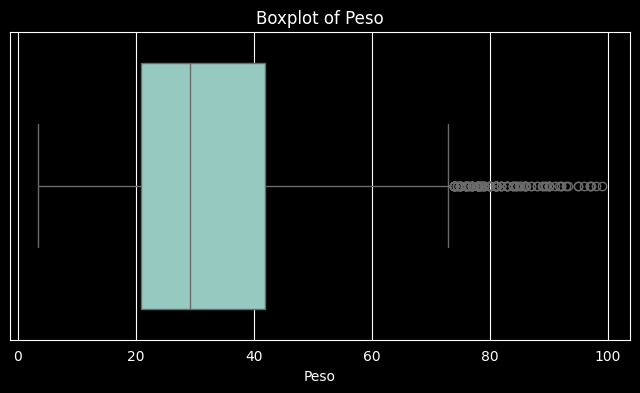

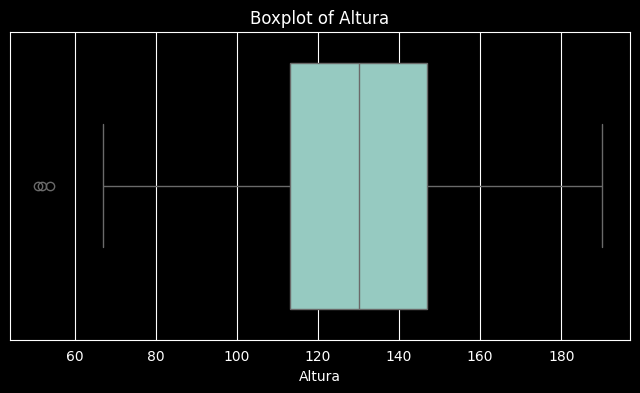

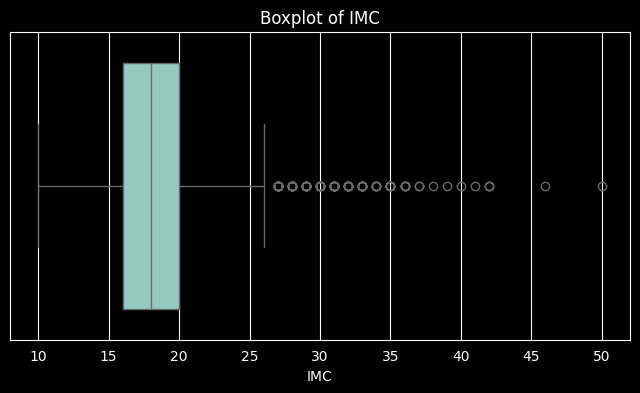

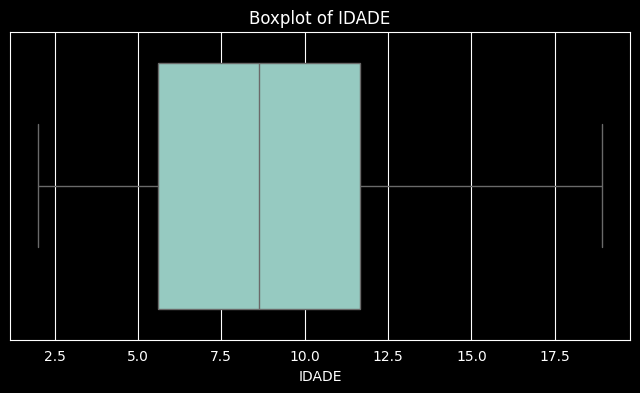

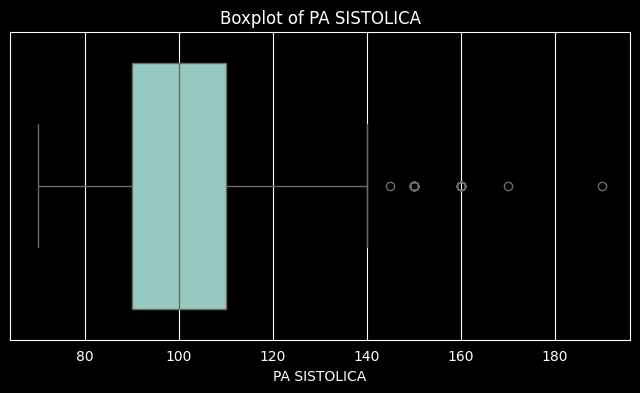

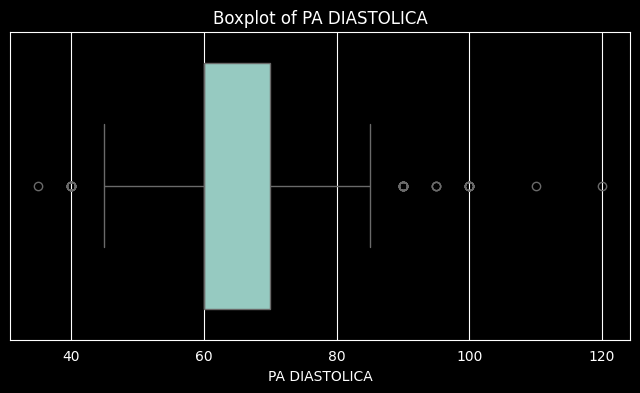

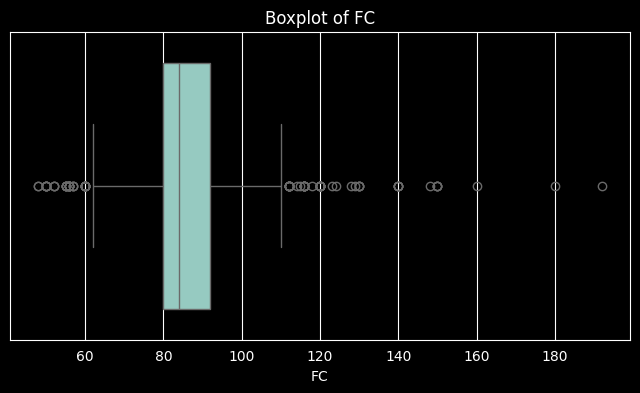

In [95]:
numeric_cols = df.select_dtypes(include='float64').columns
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


Overall, the boxplots indicate that the dataset is now free of extreme or physiologically impossible values. The weight (Peso), height (Altura), BMI (IMC), and blood pressure 
variables show distributions consistent with a heterogeneous pediatric population 
spanning ages 2–19. Some outliers are visible in Peso, Altura, IMC, PA Sistólica, PA Diastólica and FC, but all fall within clinically plausible ranges (e.g., tall adolescents, high but possible blood pressure readings, tachycardic heart rates). Because these values may represent true clinical extremes rather than data-entry errors, they were intentionally retained in the dataset. The age variable shows a clean 2–19 distribution, confirming that the age filter was applied correctly.


#### Feature Scaling


Many machine learning methods used later in this project are sensitive to the magnitude of the variables. For example, 
blood pressure values range around 100 mmHg, whereas IMC varies around 15–25. 
Without scaling, variables with larger numerical ranges would dominate distance-based 
algorithms and variance-based methods.

In [96]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

To ensure all numeric features contribute equally, we apply Z-score standardization 
using the `StandardScaler`, transforming each variable to have mean 0 and standard 
deviation 1.

The scaled numerical variables include:
- Peso  
- Altura  
- IMC  
- IDADE  
- PA Sistólica  
- PA Diastólica  
- FC  

In [97]:
df_scaled

,Peso,Altura,IMC,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,SEXO,MOTIVO1,MOTIVO2
4,0.430248,0.548315,0.411883,0.210927,OUTROS,NORMAIS,-1.473748,-1.417504,ANORMAL,NORMAL,AUSENTE,0.404547,NaN,M,5__PARECER_CARDIOLOGICO,5__ATIVIDADE_FISICA
5,-0.454370,-0.844473,0.672025,-1.176695,GS,NORMAIS,-0.095290,-0.250516,ANORMAL,DESDOB_FIXO,AUSENTE,1.303885,ASSINTOMATICO,M,2__CHECKUP,NaN
7,-0.323316,-0.612342,0.411883,-0.779088,GS,NORMAIS,0.823683,0.332978,ANORMAL,NORMAL,AUSENTE,-0.494792,ASSINTOMATICO,F,5__PARECER_CARDIOLOGICO,5__CIRURGIA
10,-0.552661,-0.380210,-0.628686,-0.685691,UR,NORMAIS,-0.095290,0.332978,ANORMAL,NORMAL,SISTOLICO,0.224679,ASSINTOMATICO,M,5__PARECER_CARDIOLOGICO,5__CIRURGIA
16,-1.470043,-1.912277,-1.409113,-1.625004,SA,NORMAIS,-1.014262,-0.250516,NORMAL,NORMAL,AUSENTE,0.854216,ASSINTOMATICO,F,5__PARECER_CARDIOLOGICO,5__CIRURGIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17859,0.174691,0.223331,0.411883,-0.133310,OUTROS,NORMAIS,-0.095290,-0.250516,ANORMAL,NORMAL,AUSENTE,-1.214263,NaN,M,5__PARECER_CARDIOLOGICO,5__CIRURGIA
17861,0.659593,0.362610,1.192310,-0.154658,NaN,NORMAIS,-0.095290,-0.250516,ANORMAL,NORMAL,AUSENTE,-0.314924,DISPNEIA,M,5__PARECER_CARDIOLOGICO,NaN
17863,-0.388843,-0.055226,-0.628686,-0.135979,GRUPO,NORMAIS,-0.095290,-0.250516,ANORMAL,NORMAL,AUSENTE,NaN,DOR_PRECORDIAL,M,5__PARECER_CARDIOLOGICO,NaN
17865,-0.225025,0.130479,-0.368544,-0.037244,SULA,NORMAIS,-1.014262,-1.417504,ANORMAL,NORMAL,AUSENTE,NaN,NaN,F,6__SUSPEITA_DE_CARDIOPATIA,6__DOR_PRECORDIAL


In [98]:
df_scaled.describe()

,Peso,Altura,IMC,IDADE,PA SISTOLICA,PA DIASTOLICA,FC
count,7.233000e+03,7.233000e+03,7.233000e+03,7.233000e+03,7.233000e+03,7.233000e+03,6.926000e+03
mean,-2.730968e-16,-6.012058e-16,1.402322e-16,3.340032e-16,-5.511053e-16,-3.084618e-16,3.529118e-16
std,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00,1.000072e+00
min,-1.928734e+00,-3.676476e+00,-2.189540e+00,-1.814468e+00,-2.852206e+00,-3.167986e+00,-3.372676e+00
25%,-7.820066e-01,-7.980467e-01,-6.286861e-01,-8.564749e-01,-1.014262e+00,-2.505160e-01,-4.947922e-01
50%,-2.446831e-01,-8.800003e-03,-1.084016e-01,-4.524982e-02,-9.528952e-02,-2.505160e-01,-1.350566e-01
75%,5.940658e-01,7.804467e-01,4.118829e-01,7.633068e-01,8.236826e-01,9.164721e-01,5.844144e-01
max,4.329119e+00,2.776777e+00,8.216150e+00,2.695303e+00,8.175460e+00,6.751413e+00,9.577802e+00


Alternative scaling techniques such as Min–Max normalization or Robust Scaling were not used because the dataset does not exhibit heavy-tailed distributions, and Z-score standardization is required for PCA and distance-based models used later. Log transformations were also unnecessary because no numeric variable showed strong positive skew after cleaning.


## Univariate Analysis

In this section, we examine the distribution of each variable individually after data cleaning and feature scaling. The objective is to understand the central tendency dispersion, and distribution shape of both numerical and categorical features. This inspection helps confirm data quality and prepare for later bivariate and multivariate analyses.

For numerical variables, we present summary statistics, histograms, kernel density estimates (KDE), and boxplots. For categorical variables, we present frequency tables and bar charts.

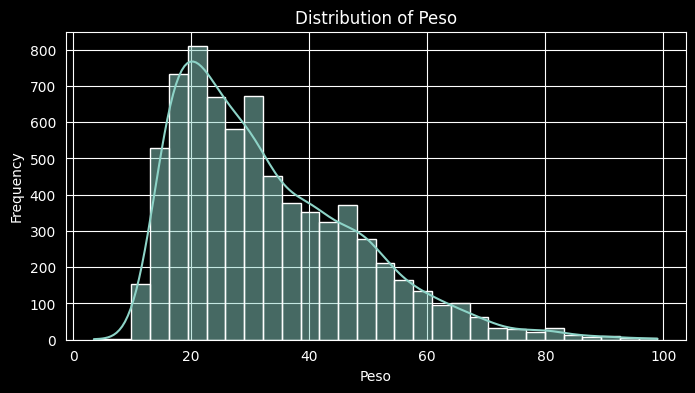

count    7233.000000
mean       32.934066
std        15.261881
min         3.500000
25%        21.000000
50%        29.200000
75%        42.000000
max        99.000000
Name: Peso, dtype: float64

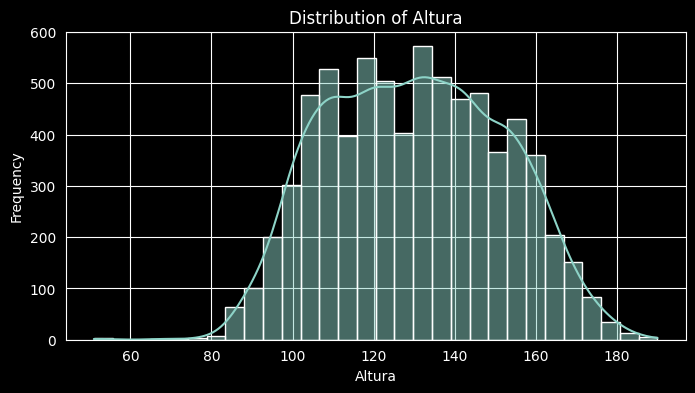

count    7233.000000
mean      130.189548
std        21.541016
min        51.000000
25%       113.000000
50%       130.000000
75%       147.000000
max       190.000000
Name: Altura, dtype: float64

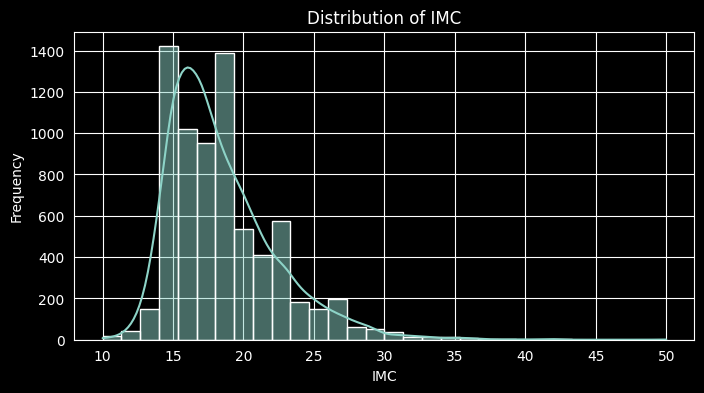

count    7233.000000
mean       18.416701
std         3.844317
min        10.000000
25%        16.000000
50%        18.000000
75%        20.000000
max        50.000000
Name: IMC, dtype: float64

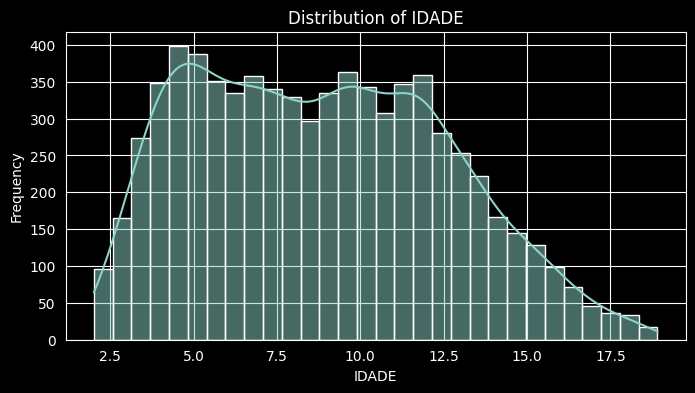

count    7233.000000
mean        8.809570
std         3.747678
min         2.010000
25%         5.600000
50%         8.640000
75%        11.670000
max        18.910000
Name: IDADE, dtype: float64

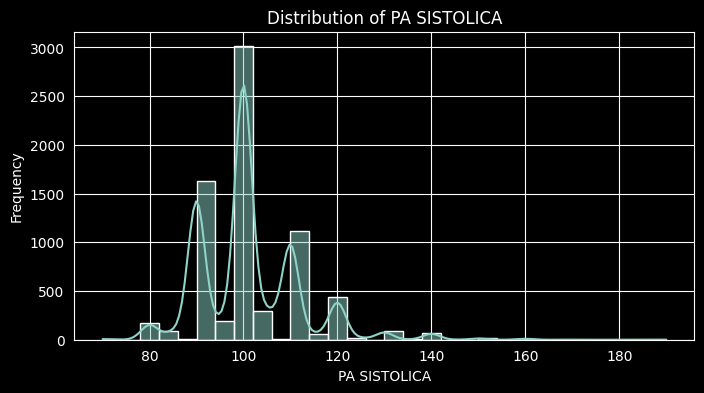

count    7233.000000
mean      101.036914
std        10.882475
min        70.000000
25%        90.000000
50%       100.000000
75%       110.000000
max       190.000000
Name: PA SISTOLICA, dtype: float64

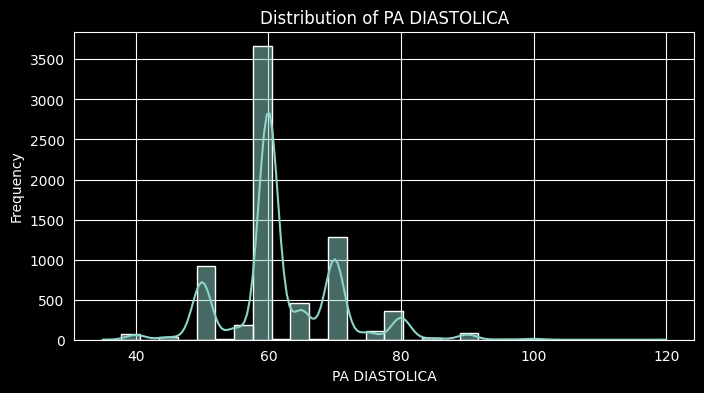

count    7233.000000
mean       62.146689
std         8.569660
min        35.000000
25%        60.000000
50%        60.000000
75%        70.000000
max       120.000000
Name: PA DIASTOLICA, dtype: float64

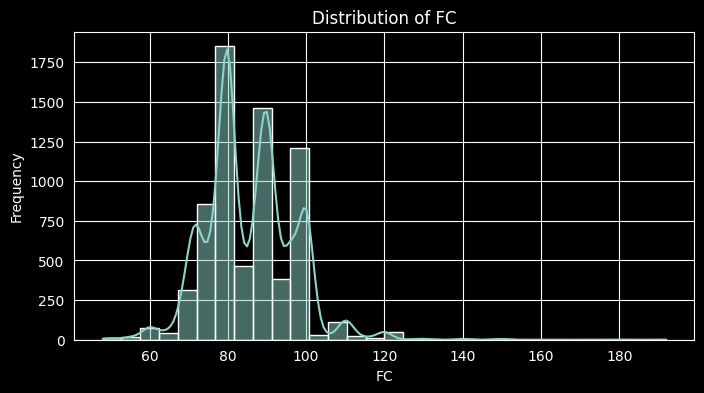

count    6926.000000
mean       85.501733
std        11.120083
min        48.000000
25%        80.000000
50%        84.000000
75%        92.000000
max       192.000000
Name: FC, dtype: float64

In [99]:
numeric_cols = ['Peso', 'Altura', 'IMC', 'IDADE', 
                'PA SISTOLICA', 'PA DIASTOLICA', 'FC']

for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

    display(df[col].describe())


#### Summary of Numerical Variables

- **Peso (weight):** Displays a mild right tail, with most values concentrated between 10–40 kg and a small number of heavier adolescents reaching up to ~100 kg. No impossible or corrupted values remain after cleaning.

- **Altura (height):** Exhibits a wide distribution (≈50–190 cm) reflecting growth across ages 2–19. The left tail is thinner because the dataset contains fewer very young children, producing a mild left skew with more observations in the adolescent height range. All values are physiologically plausible and consistent with pediatric growth patterns.

- **IMC (BMI):** Shows a clearly right-skewed distribution. Most patients have IMC values in a lower range (around 15–20), while a long right tail extends towards higher values, reflecting a smaller group of overweight or obese adolescents. These higher IMC values are rare but still clinically plausible.

- **Idade (age):** Ranges from 2 to 19 years, with more patients concentrated in school-age and early adolescent groups and fewer at the younger and oldest extremes. This reflects the pediatric population seen in the clinic after applying the 2–19 age filter.

- **PA Sistólica / PA Diastólica (blood pressure):** Both variables show central distributions consistent with pediatric norms (SBP ~90–110; DBP ~50–70). Mild high outliers remain but are clinically plausible and therefore retained.

- **FC (heart rate):** Shows a broad and irregular distribution, with several local peaks between approximately 70 and 120 bpm. The distribution is multimodal rather than centered around a single value, reflecting the natural variability of heart rate across different ages and clinical states. A gradual right tail extends toward higher values (tachycardia), but all observations remain within the physiologically acceptable range defined during data cleaning (40–220 bpm).




In [100]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
categorical_cols


Index(['Convenio', 'PULSOS', 'NORMAL X ANORMAL', 'B2', 'SOPRO', 'HDA 1',
       'SEXO', 'MOTIVO1', 'MOTIVO2'],
      dtype='object')

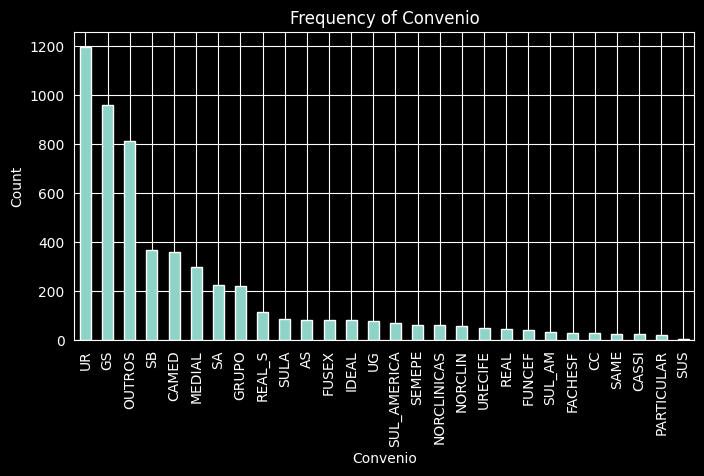

Convenio
NaN            1738
UR             1198
GS              958
OUTROS          812
SB              369
CAMED           358
MEDIAL          298
SA              225
GRUPO           220
REAL_S          115
SULA             84
AS               82
IDEAL            80
FUSEX            80
UG               76
SUL_AMERICA      68
SEMEPE           63
NORCLINICAS      60
NORCLIN          57
URECIFE          47
REAL             43
FUNCEF           40
SUL_AM           34
FACHESF          30
CC               27
SAME             26
CASSI            24
PARTICULAR       19
SUS               2
Name: count, dtype: int64

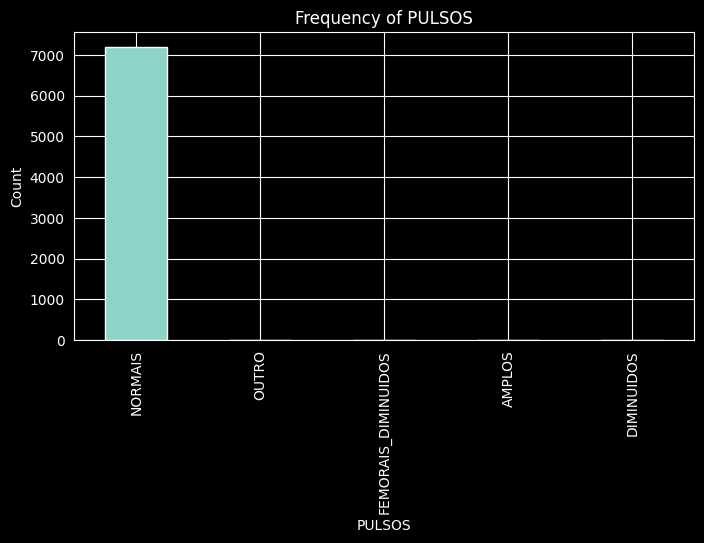

PULSOS
NORMAIS                7199
NaN                       9
OUTRO                     9
FEMORAIS_DIMINUIDOS       7
AMPLOS                    7
DIMINUIDOS                2
Name: count, dtype: int64

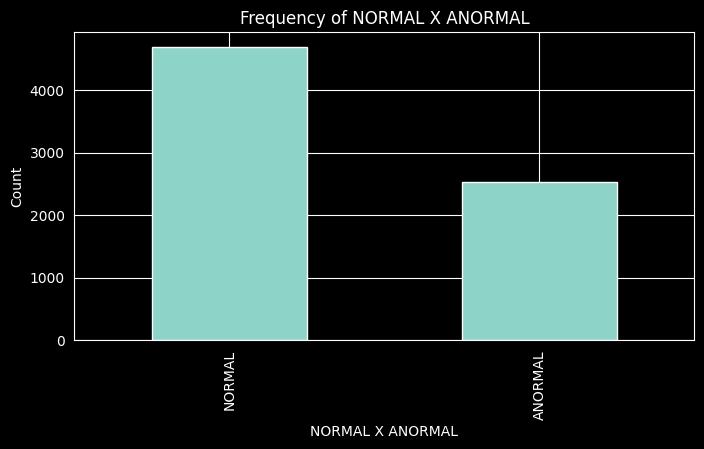

NORMAL X ANORMAL
NORMAL     4696
ANORMAL    2537
Name: count, dtype: int64

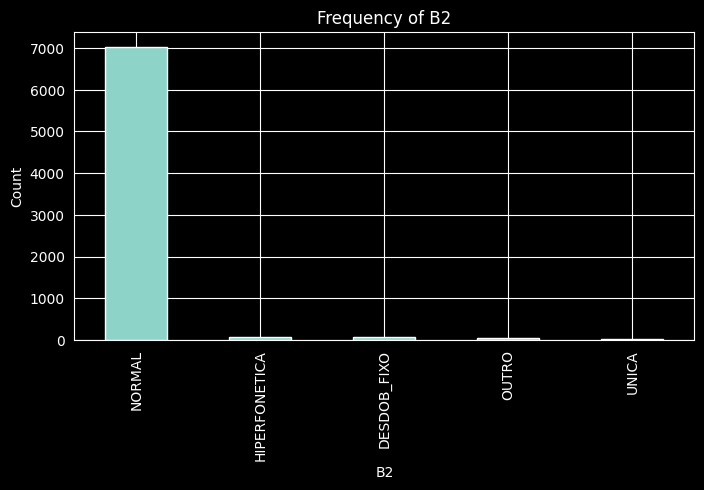

B2
NORMAL           7039
HIPERFONETICA      67
DESDOB_FIXO        63
OUTRO              51
UNICA              11
NaN                 2
Name: count, dtype: int64

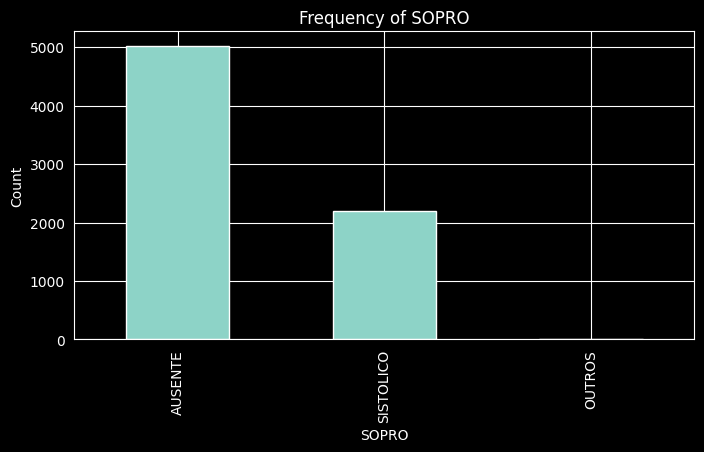

SOPRO
AUSENTE      5017
SISTOLICO    2202
OUTROS         14
Name: count, dtype: int64

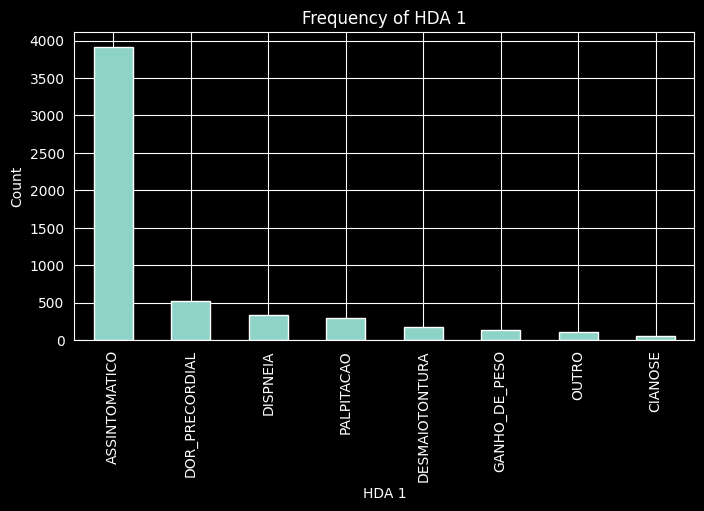

HDA 1
ASSINTOMATICO     3917
NaN               1688
DOR_PRECORDIAL     526
DISPNEIA           335
PALPITACAO         289
DESMAIOTONTURA     174
GANHO_DE_PESO      138
OUTRO              113
CIANOSE             53
Name: count, dtype: int64

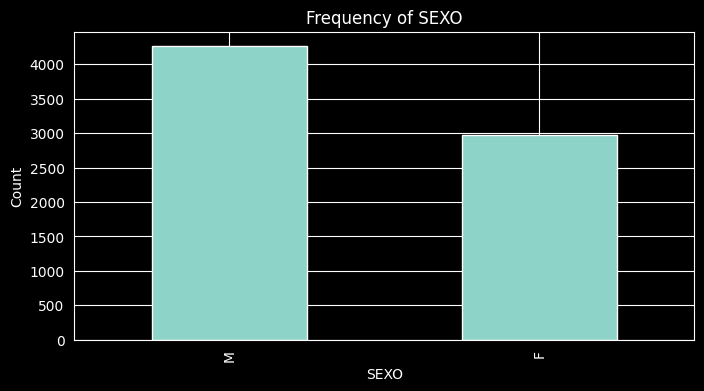

SEXO
M    4261
F    2972
Name: count, dtype: int64

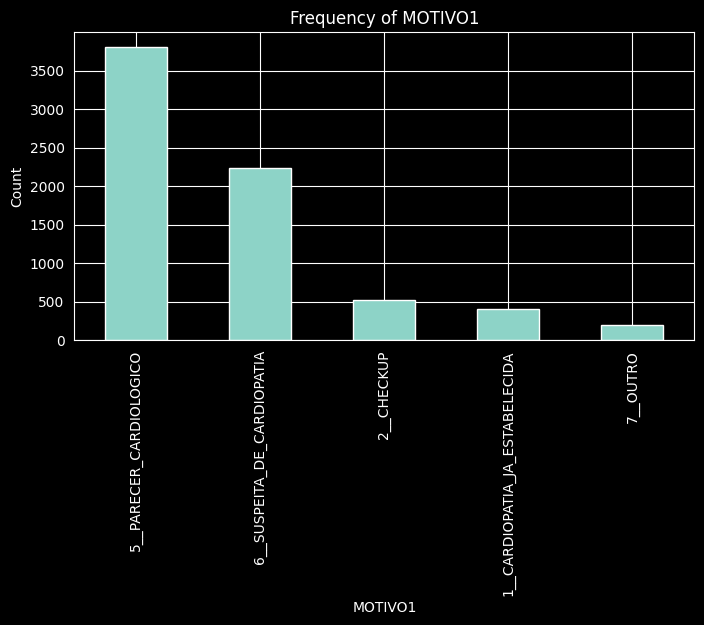

MOTIVO1
5__PARECER_CARDIOLOGICO           3809
6__SUSPEITA_DE_CARDIOPATIA        2242
2__CHECKUP                         519
1__CARDIOPATIA_JA_ESTABELECIDA     410
7__OUTRO                           194
NaN                                 59
Name: count, dtype: int64

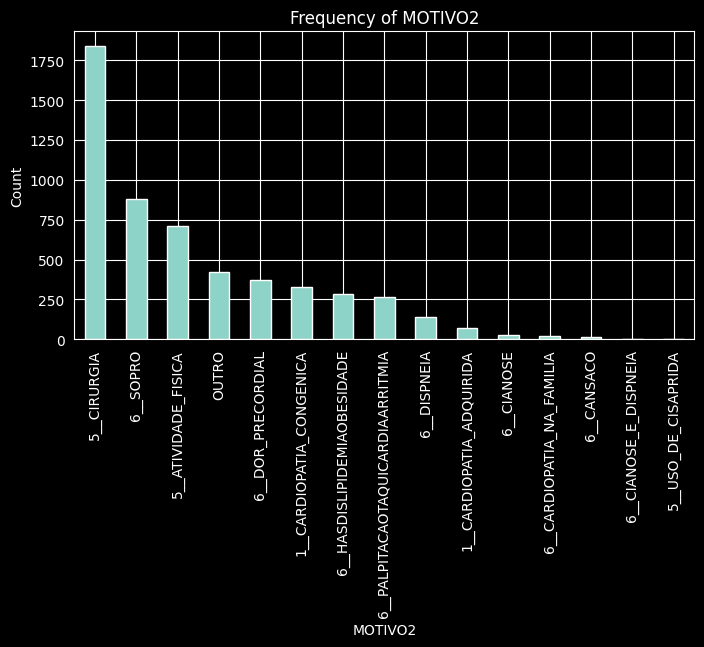

MOTIVO2
NaN                                 1859
5__CIRURGIA                         1839
6__SOPRO                             880
5__ATIVIDADE_FISICA                  708
OUTRO                                423
6__DOR_PRECORDIAL                    374
1__CARDIOPATIA_CONGENICA             326
6__HASDISLIPIDEMIAOBESIDADE          284
6__PALPITACAOTAQUICARDIAARRITMIA     263
6__DISPNEIA                          137
1__CARDIOPATIA_ADQUIRIDA              71
6__CIANOSE                            29
6__CARDIOPATIA_NA_FAMILIA             24
6__CANSACO                            14
6__CIANOSE_E_DISPNEIA                  1
5__USO_DE_CISAPRIDA                    1
Name: count, dtype: int64

In [101]:
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f"Frequency of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

    display(df[col].value_counts(dropna=False))


#### Summary of Categorical Variables

- **SEXO:** The dataset shows a relatively balanced distribution between male (58.9%) and
  female (41.1%) patients, indicating no strong gender bias in clinic attendance.

- **CONVENIO (insurance provider):** The raw variable contained over 400 unique
  categories due to spelling variations and rare insurance types. After grouping
  infrequent categories into "OUTROS", the distribution clearly shows a small number
  of dominant providers (GS, UR, SB) and a long tail of rare plans. This imbalance
  must be considered during modeling, as CONVENIO may contribute limited predictive
  power compared to clinical variables.

- **NORMAL_X_ANORMAL:** The target variable is moderately imbalanced, with the
  majority of patients classified as NORMAL. This imbalance should be accounted for
  in predictive modeling by using appropriate metrics such as balanced accuracy or
  AUC, or by applying resampling techniques.

- **SOPRO:** Most children do not present an audible murmur (AUSENTE), while a
  smaller but clinically meaningful subgroup exhibits SISTOLICO murmurs. Rare
  murmur types were grouped into OUTROS to avoid excessive category sparsity.

- **B2 (second heart sound):** The majority of patients have a NORMAL B2. Less
  frequent categories (HIPERFONETICA, DESDOB_FIXO, UNICA) remain after normalization
  and represent specific clinical findings.

- **PULSOS:** Most patients exhibit NORMAL pulses. Categories such as AMPLAS and
  FRACOS appear less frequently, reflecting variations in hemodynamic status.
  Outliers and corrupted values were corrected or grouped during preprocessing.

- **HDA1 (history of disease):** This variable contains numerous categories with
  highly uneven frequencies. A few clinical histories are common, while many appear
  only in a handful of cases. Such sparsity may require grouping or alternative
  encoding strategies for predictive modeling.

- **MOTIVO1 and MOTIVO2 (reason for referral):** These are free-text categorical
  fields with a very large number of unique entries and a long-tailed distribution.
  Only a few referral reasons are common (e.g., chest pain, murmur evaluation),
  while the majority are rare or highly specific. For modeling, these variables may
  need grouping, embedding, or removal if too sparse.


### Variable Usefulness Assessment

Based on the univariate exploration, each variable can be classified according to
its potential usefulness for predictive modeling:

##### **Likely Strong Predictors**
- **PA Sistólica, PA Diastólica:** Clinically relevant measurements; their
  distributions are clean and within physiological ranges.
- **FC (heart rate):** Shows multimodal structure that may reveal physiological
  differences between NORMAL and ANORMAL groups.
- **IMC, Peso, Altura:** Despite some skewness, these variables are continuous,
  meaningful, and likely contribute to prediction.

##### **Moderate Predictors**
- **SOPRO, B2, PULSOS:** Categorical clinical findings that are imbalanced but
  medically meaningful. Even rare categories may carry diagnostic value.
- **SEXO:** Mild imbalance; may help explain subtle differences in disease
  patterns.

##### **Weak or Problematic Predictors (Need Extra Processing)**
- **CONVENIO:** High cardinality in raw form; grouped version may have limited
  clinical relevance but can still be included cautiously.
- **HDA1:** Extremely sparse, with many rare categories. Requires grouping or
  keyword extraction.
- **MOTIVO1, MOTIVO2:** Free-text–like categorical variables with very high
  cardinality. They cannot be used in raw form and need substantial preprocessing
  (grouping into themes or text embeddings).

##### **Removed Variables**
- **PPA:** Dropped due to corruption, inconsistent format, and lack of reliable
  clinical meaning in the dataset.



#### Target 

The target variable **NORMAL_X_ANORMAL** is moderately imbalanced, with NORMAL cases forming the majority. This impacts model evaluation:

- A naïve classifier predicting only NORMAL could achieve deceptively high
  accuracy.
- Therefore, accuracy alone is not a reliable metric.
- We will rely on:
  - **Balanced Accuracy**
  - **AUC (Area Under ROC Curve)**
  - **Sensitivity and Specificity**
- Resampling techniques (e.g., Random Oversampling or SMOTE) may be explored if the minority class is underrepresented in training splits.

#### Key Takeaways from Univariate Analysis

- The dataset contains clinically meaningful variables with varying degrees of
  imbalance and skewness.
- Most numeric variables are clean and usable after filtering.
- Several categorical variables (SOPRO, B2, PULSOS) are imbalanced but clinically
  informative.
- High-cardinality administrative variables (CONVENIO, MOTIVO1/2, HDA1) require
  grouping or advanced encoding.
- The target variable's imbalance requires careful metric selection and possibly
  resampling.

## Bivariate Analysis

#### **Correlation Analysis (Numeric vs Numeric)**

To explore relationships between continuous variables, we compute the Pearson correlation matrix. This allows us to identify which variables move together, which may indicate redundancy, collinearity, or clinically expected associations.

A heatmap is used to visualize the correlation strengths.

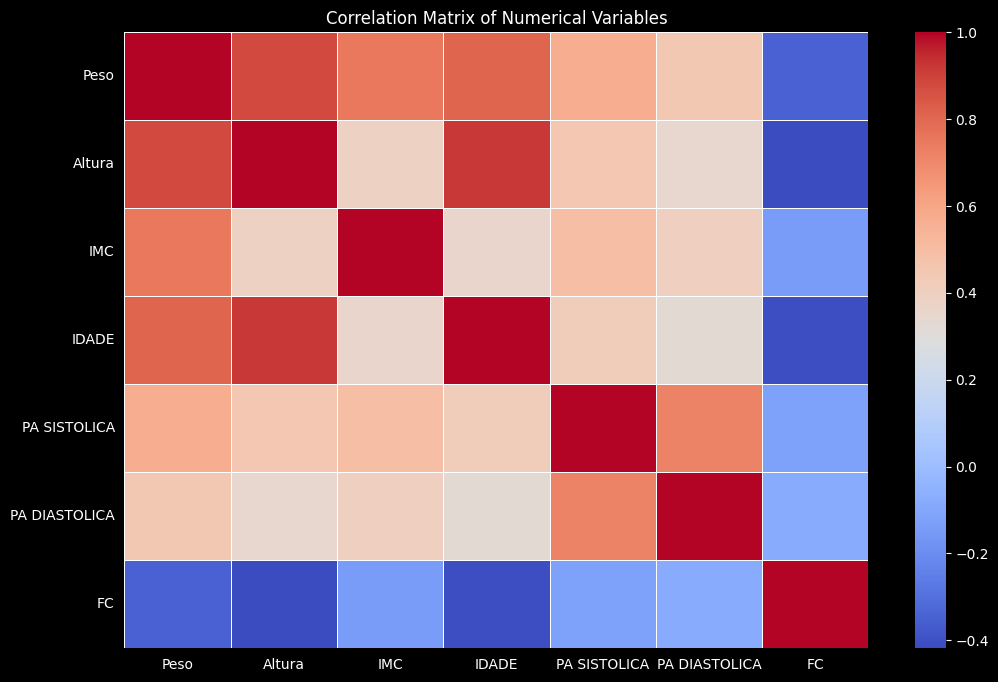

In [102]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix of Numerical Variables")
plt.show()


#### Interpretation of the Correlation Matrix

- **Peso (weight) shows strong correlation with both Altura (height) and IMC (BMI)** ,which is expected since heavier children tend to be taller, and BMI is heavily influenced by weight.

- **Altura correlates moderately with IMC**, indicating that height alone does not strongly determine BMI in a pediatric population with diverse growth stages and body proportions.

- **Idade (age) shows a moderate positive correlation with both Altura and Peso.**
This aligns with normal pediatric development: as children grow older, they typically become both taller and heavier. However, because growth is not linear across childhood and adolescence (with rapid acceleration during puberty and plateaus afterward), these correlations are moderate rather than extremely high.

- **PA Sistólica and PA Diastólica show a strong correlation**, reflecting the fact that both measure related physiological dimensions of arterial pressure.

- **FC (heart rate) displays very weak correlations with all other numeric variables**, suggesting that heart rate varies independently from height, weight, BMI, and blood pressure in this dataset. The only notable relationship is the **negative correlation between Idade and FC**, confirming that younger children physiologically have higher heart rates.

- Overall, the correlation structure shows that most clinical variables are not strongly linearly dependent. This reduces concerns about multicollinearity and supports their use as independent predictors in upcoming modeling steps.


#### **Scatterplots for Key Numeric Relationships**

Scatterplots allow visual inspection of nonlinear patterns, clusters, or trends that correlations alone may not reveal.


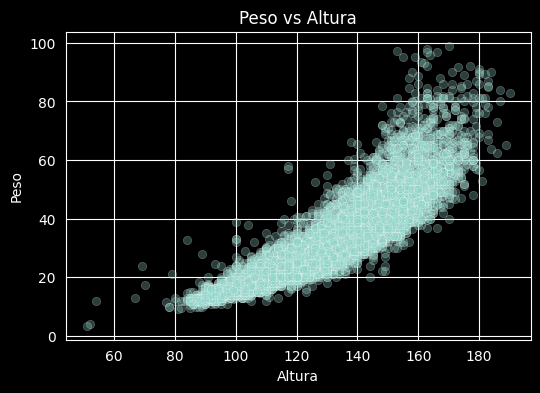

In [103]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='Altura', y='Peso', alpha=0.3)
plt.title("Peso vs Altura")
plt.show()


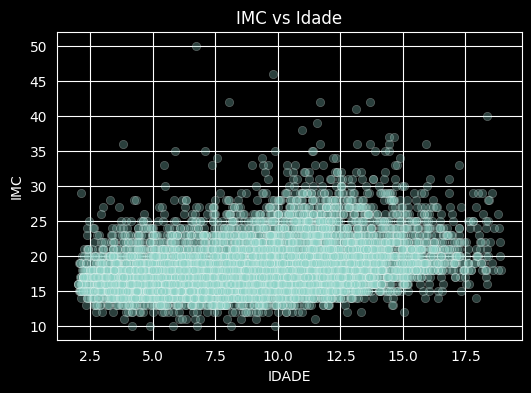

In [104]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='IDADE', y='IMC', alpha=0.3)
plt.title("IMC vs Idade")
plt.show()


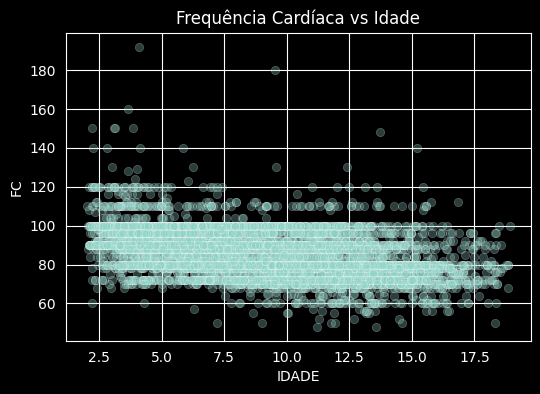

In [105]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='IDADE', y='FC', alpha=0.3)
plt.title("Frequência Cardíaca vs Idade")
plt.show()


#### Interpretation

- **Peso vs Altura:** Shows a clear positive relationship, consistent with normal pediatric growth patterns. The spread increases with age, as expected.

- **IMC vs Idade:** BMI appears stable across age groups with large variation. This suggests obesity or underweight status is not strongly age-dependent in this dataset.

- **FC vs Idade:** Heart rate decreases slightly with age, consistent with pediatric
  physiology (younger children naturally have faster heart rates).


#### **Numerical Variables by Diagnostic Group (Boxplots)**

To understand whether clinical measurements differ between NORMAL and ANORMAL
patients, we visualize the distribution of numerical variables across these
groups using boxplots.


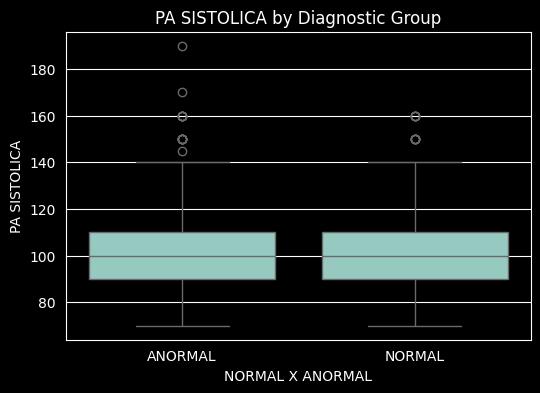

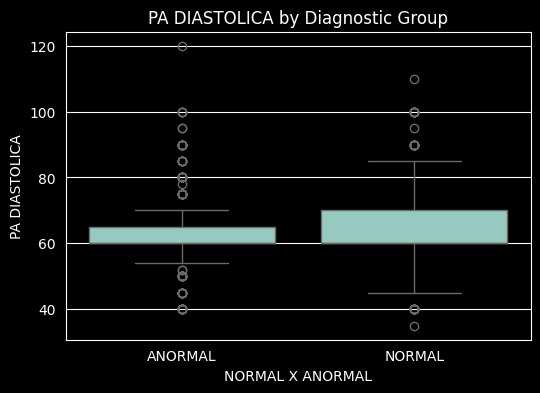

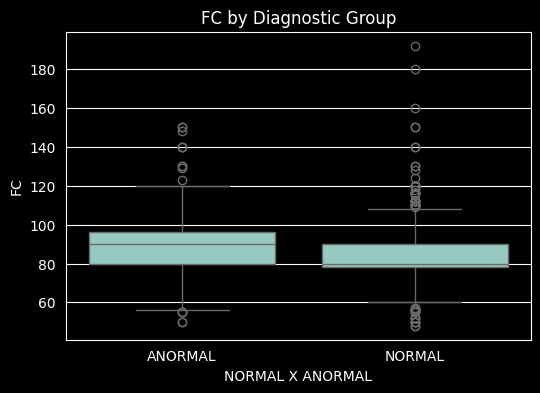

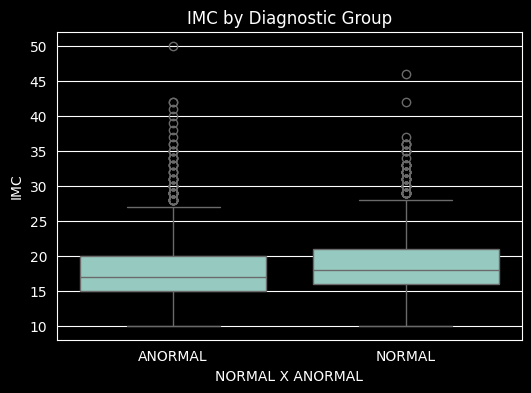

In [106]:
vars_to_plot = ['PA SISTOLICA', 'PA DIASTOLICA', 'FC', 'IMC']

for col in vars_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='NORMAL X ANORMAL', y=col)
    plt.title(f"{col} by Diagnostic Group")
    plt.show()


In [107]:
df.groupby('NORMAL X ANORMAL')['PA DIASTOLICA'].describe()[['mean', '50%', 'std']]


,mean,50%,std
NORMAL X ANORMAL,,,
ANORMAL,61.911313,60.0,8.259137
NORMAL,62.273850,60.0,8.731052


#### Interpretation of Boxplots by Diagnostic Group

- **PA Sistólica:** The distributions of systolic pressure for NORMAL and ANORMAL patients are very similar. Both groups have nearly identical medians and IQRs.
Both groups contain high-end outliers, with ANORMAL presenting slightly more extreme maximum values. Overall, systolic pressure does not clearly separate NORMAL from ANORMAL patients in a meaningful way.

- **PA Diastólica:** Numerical summaries confirm that diastolic pressure is almost identical for NORMAL and ANORMAL patients. Both groups share the same median (60 mmHg), and their mean values differ by less than 1 mmHg (62.27 vs 61.91), which is clinically negligible. The NORMAL group shows slightly higher variability (std = 8.73 vs 8.26), consistent with its marginally wider box in the boxplot. Overall, diastolic pressure does not meaningfully distinguish between diagnostic groups.

- **FC (heart rate):**
The FC distributions for NORMAL and ANORMAL patients are overall very similar.
Both groups have close medians, but the NORMAL group shows a slightly lower median heart rate and a somewhat smaller IQR, indicating less variability.
However, the overlap between the two groups is large, so heart rate alone is unlikely to be a strong discriminator between NORMAL and ANORMAL diagnoses.

- **IMC (BMI):**
The BMI distributions for NORMAL and ANORMAL patients are almost identical. The NORMAL group shows a very slightly higher median BMI, but the difference is small and the IQRs of the two groups largely overlap. Both groups also display similar patterns of high-end outliers. These observations suggest that BMI does not meaningfully distinguish between NORMAL and ANORMAL diagnoses and is unlikely to serve as a strong standalone predictor.



#### **Categorical Features vs Diagnostic Group**

To explore potential associations between categorical variables and the target class (NORMAL/ANORMAL), we compare the frequency distributions using grouped bar charts.

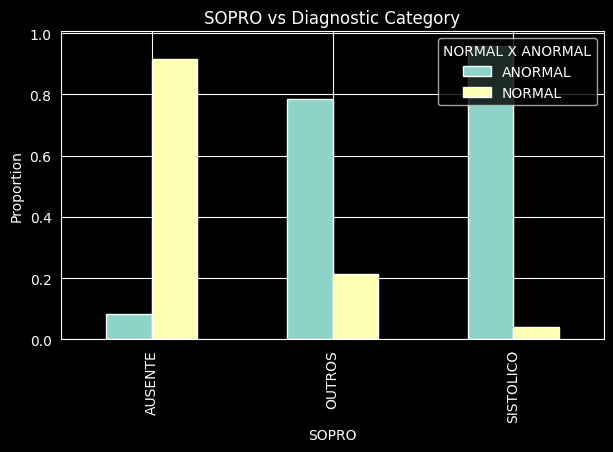

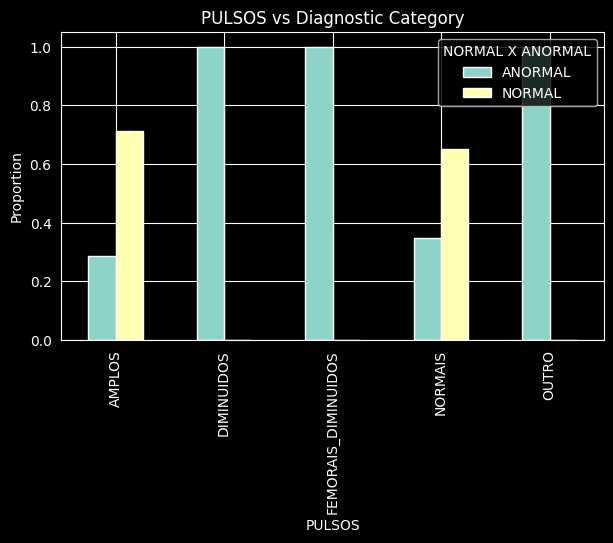

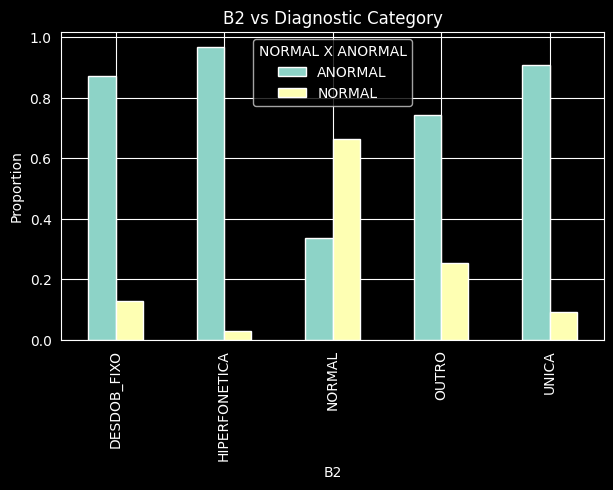

In [108]:
for col in ['SOPRO', 'PULSOS', 'B2']:
    pd.crosstab(df[col], df['NORMAL X ANORMAL'], normalize='index').plot(
        kind='bar', figsize=(7,4))
    plt.title(f"{col} vs Diagnostic Category")
    plt.ylabel("Proportion")
    plt.show()


#### Interpretation

- **SOPRO:** Children with systolic murmurs (SISTÓLICO) are much more likely to be classified as ANORMAL, whereas those with AUSENTE murmurs are mostly NORMAL.
SOPRO shows clear predictive value.

- **PULSOS:** Normal pulses (NORMAIS) are more frequent among NORMAL patients. DIMINUIDOS and FEMORAIS_DIMINUIDOS show strong association with ANORMAL cases, indicating clinically relevant circulatory abnormalities. In contrast, AMPLOS pulses are mostly seen in NORMAL patients, suggesting that they do not represent a reliable indicator of pathology. Therefore, only some categories of PULSOS offer predictive value for diagnosis.

- **B2:** A NORMAL B2 corresponds mostly to NORMAL cases. Abnormal B2 patterns (HIPERFONETICA, DESDOB_FIXO, etc.) show higher proportions of ANORMAL diagnoses.
However, rare categories should be interpreted cautiously due to small sample sizes.



#### **Summary of Bivariate Analysis**

The bivariate exploration between categorical predictors and the diagnostic outcome (NORMAL vs ANORMAL) reveals clinically coherent and statistically relevant patterns. Variables directly related to cardiovascular assessment - particularly SOPRO, PULSOS, and B2 - exhibit visible differences in their proportional distributions across diagnostic groups. Systolic murmurs (SOPRO = SISTÓLICO) and abnormal second heart sounds (e.g., B2 = Hiperfonética, Desdob fixo, etc) appear more frequently among ANORMAL cases, suggesting meaningful diagnostic associations. Conversely, categories with low occurrence (e.g., rare pulse types, uncommon SOPRO variants) show unstable proportions and should be interpreted cautiously.

Administrative features such as Convênio demonstrate no consistent relationship with diagnostic outcome, as expected from a non-clinical variable. Overall, the patterns observed in this section help identify which categorical predictors may contribute valuable information to downstream modeling, while also highlighting those with limited discriminative power. These findings establish the foundation for the multivariate and predictive modeling steps that follow.


## Multivariate Analysis

### Numerical

#### **Pairwise Multivariate Patterns by Diagnostic Group**

To evaluate how numerical variables jointly relate to the diagnostic outcome, we use a pairplot.

This allows visualization of:

- Scatterplots of every pair of numerical predictors

- Kernels of distributions within each class

- Overlaps or subtle shifts between NORMAL and ANORMAL

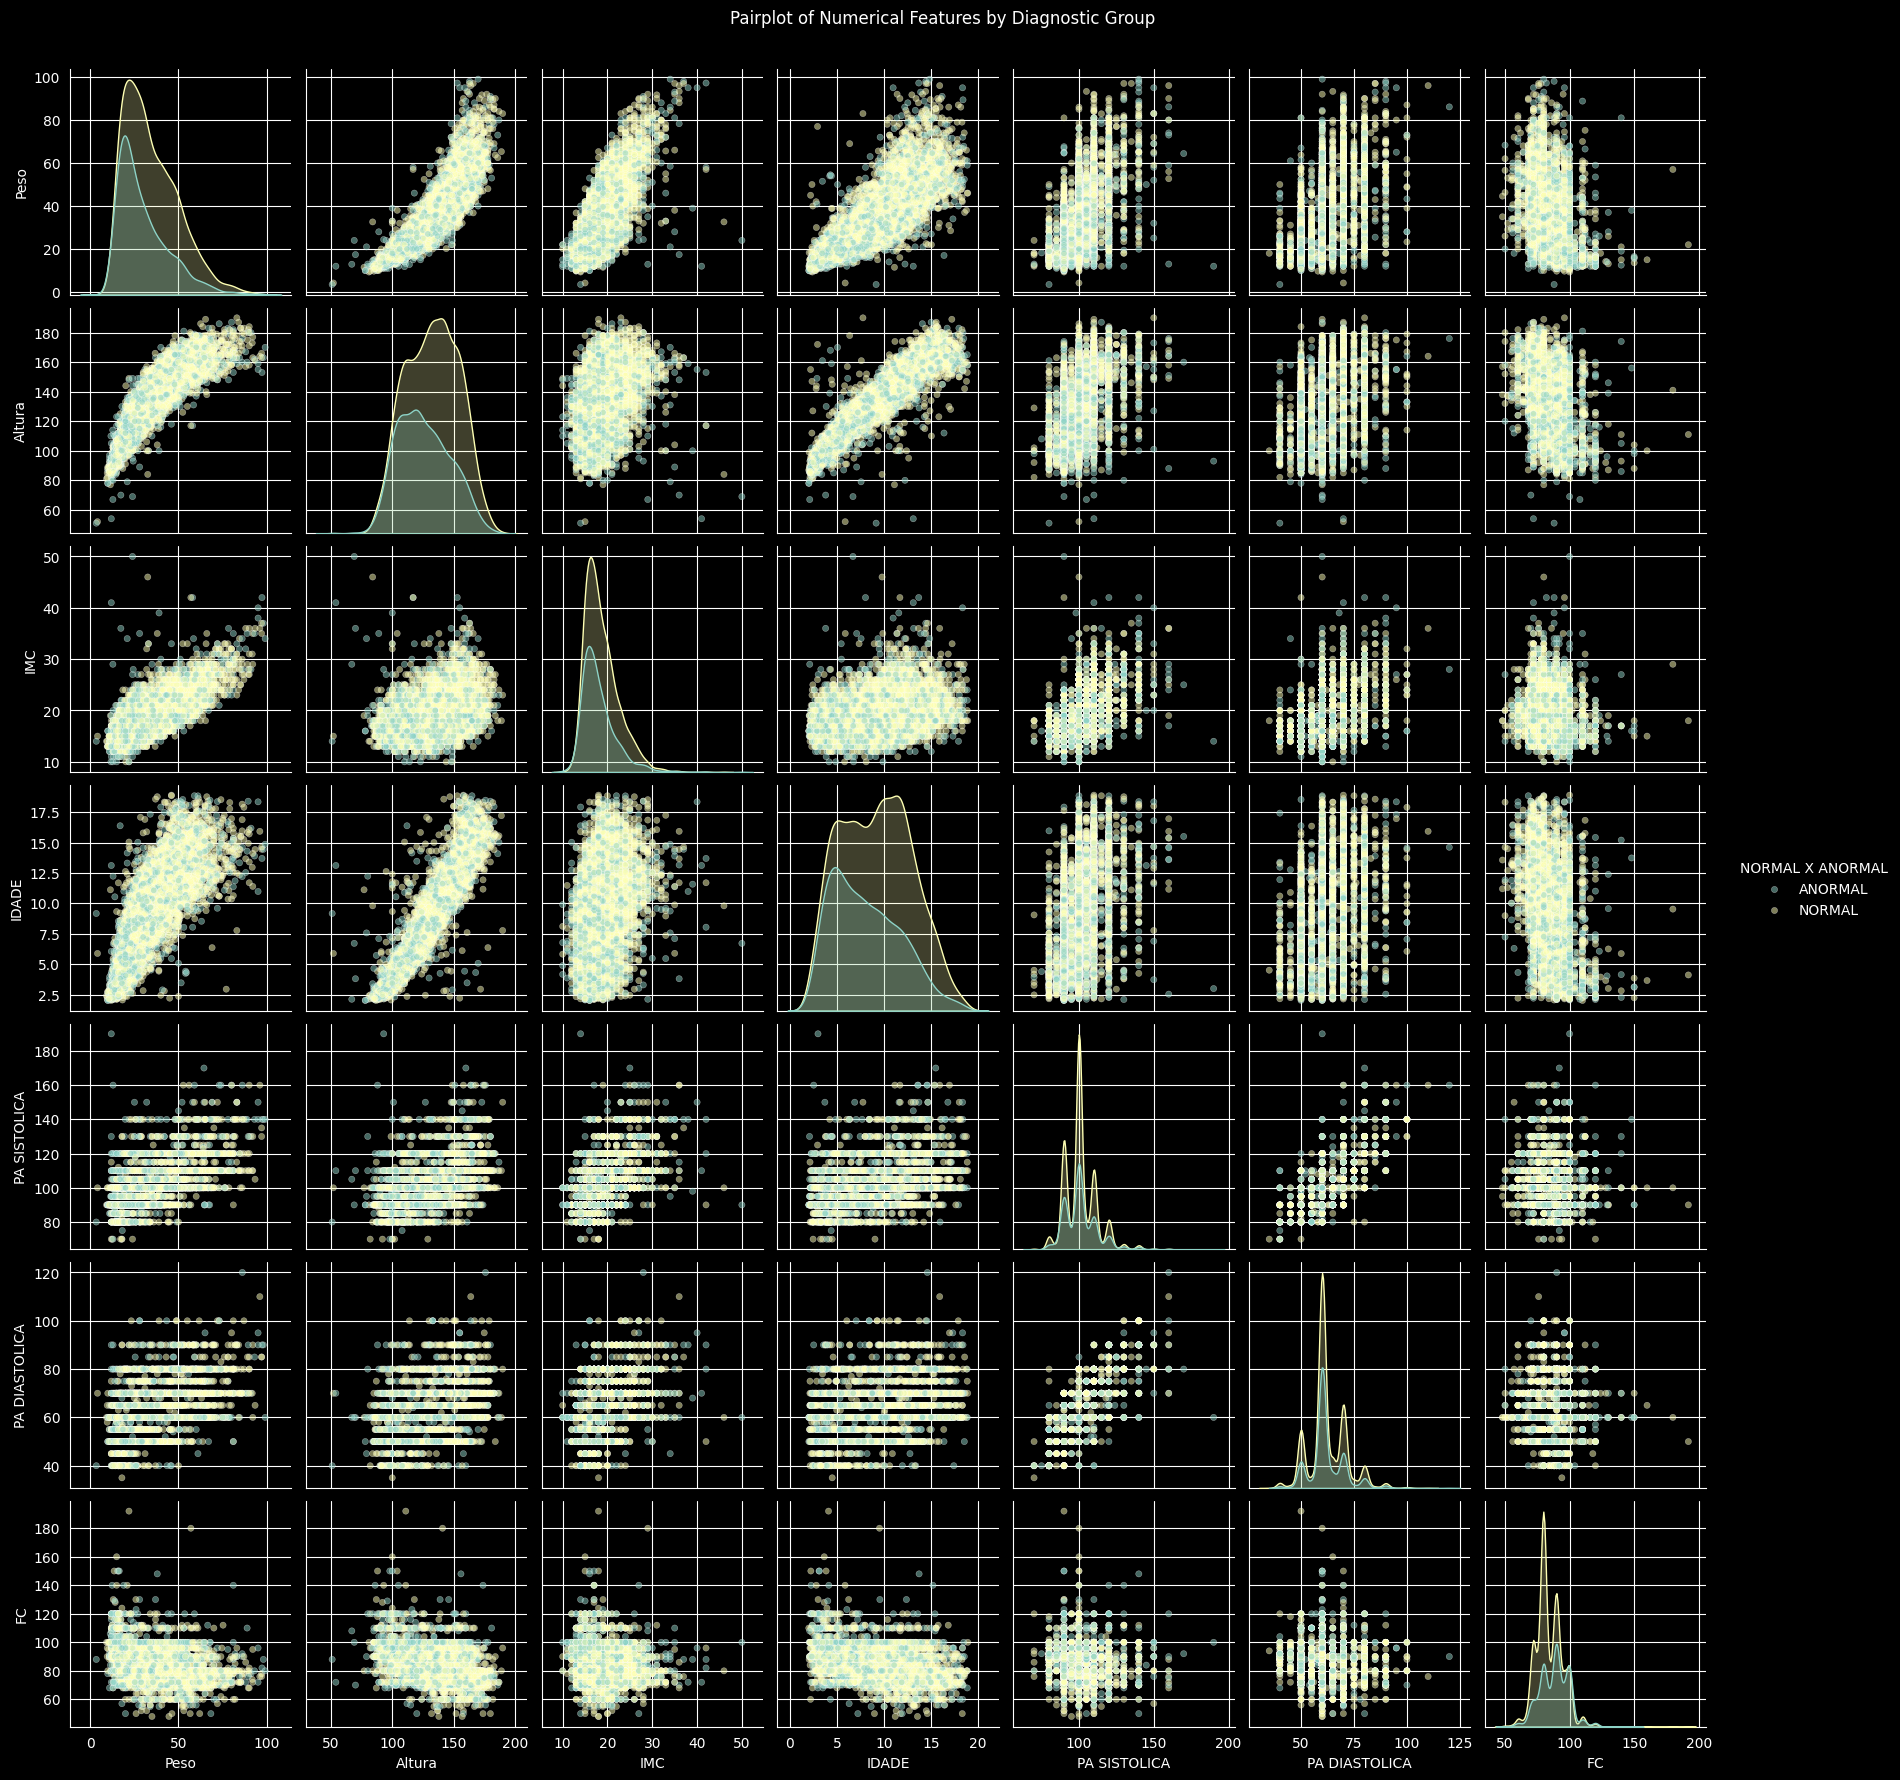

In [109]:
sns.pairplot(
    df,
    vars=numeric_cols,
    hue="NORMAL X ANORMAL",
    diag_kind="kde",
    plot_kws={'alpha': 0.5, 's': 20}
)
plt.suptitle("Pairplot of Numerical Features by Diagnostic Group", y=1.02)
plt.show()


#### Interpretation

The pairplot reveals several important multivariate patterns in the dataset:

- **Strong Overlap Between NORMAL and ANORMAL**: Across all numeric variables, the NORMAL and ANORMAL points overlap heavily. This indicates that no single variable is capable of visually separating the diagnostic classes. Any meaningful separation will require multivariate machine learning methods.

- **Growth Variables Behave as Expected (Peso, Altura, IMC)**: Peso and Altura show a clear positive linear relationship, reflecting normal child growth. IMC aligns with expected interactions between weight and height. However, both diagnostic groups occupy the same ranges, which shows these variables are not discriminatory for detecting cardiac abnormalities.

- **Blood Pressure Shows a Slight Diagnostic Trend**: PA Sistólica and PA Diastólica are moderately correlated with one another. NORMAL patients show a slight tendency toward higher values, but the overlap with ANORMAL patients is still very large. Thus, blood pressure provides weak but potentially useful predictive information.

- **Heart Rate (FC) Reflects Expected Physiology, Not Diagnosis**: FC decreases with age, matching pediatric physiology. NORMAL and ANORMAL children show almost identical FC distributions at every age. This confirms that heart rate alone is not a meaningful predictor.

- **Age Interacts Normally With Growth Variables**: Older children tend to be taller, heavier, and have more stable BMI. However, the diagnostic groups again overlap entirely.
Age does not distinguish NORMAL from ANORMAL cases.

#### **Combined Boxplots by Group (Multivariate View of Shifts)**

To examine class differences more efficiently, we display all boxplots in a grid. This allows direct comparison of median and variability shifts across several predictors at once.

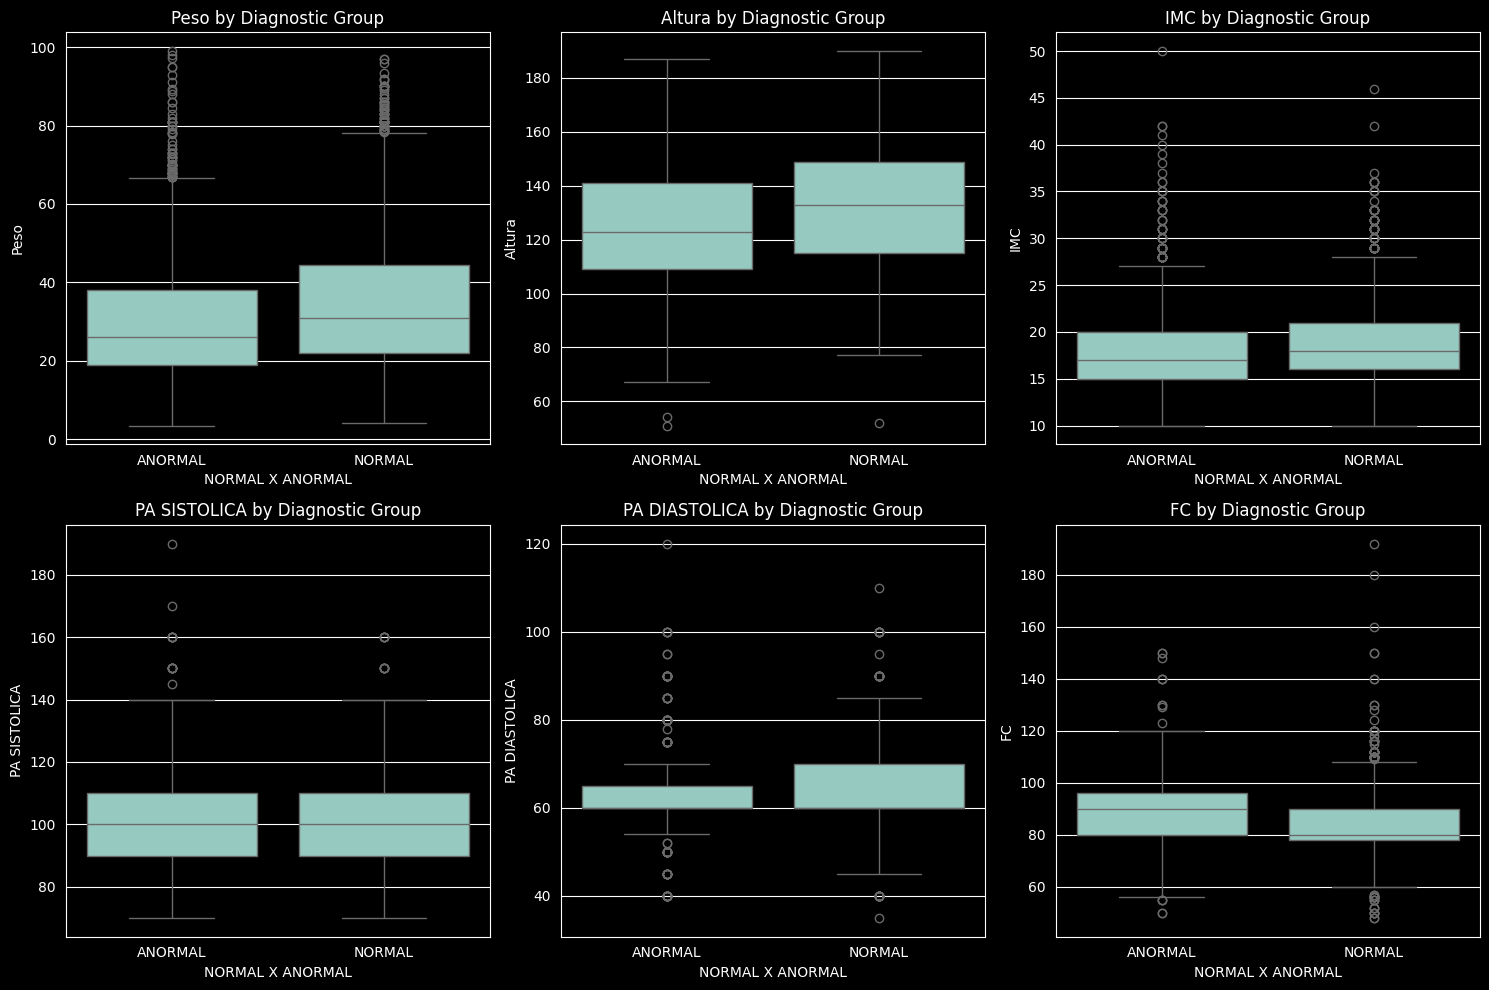

In [110]:
vars_to_plot = ['Peso', 'Altura', 'IMC', 'PA SISTOLICA', 'PA DIASTOLICA', 'FC']

fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()

for i, col in enumerate(vars_to_plot):
    sns.boxplot(data=df, x="NORMAL X ANORMAL", y=col, ax=axes[i])
    axes[i].set_title(f"{col} by Diagnostic Group")

plt.tight_layout()
plt.show()


#### Interpretation

No numeric variable shows a strong separation between NORMAL and ANORMAL children.

The only mild tendencies observed:

- NORMAL children are slightly heavier, taller, and have slightly lower FC.

- ANORMAL children have slightly higher heart rate (FC) variability.

These small differences are not enough for reliable classification individually.

This confirms that single variables are weak predictors so we must rely on multivariate models (SVM, Decision Trees, Bayesian Networks, etc.) to capture subtle patterns.



#### **Feature-Target Correlation (Point-Biserial)**

To quantify how strongly each numerical variable relates to the binary outcome, we compute point-biserial correlations.

Since NORMAL and ANORMAL form a binary class, this metric is appropriate and interpretable.

In [111]:
target = df["NORMAL X ANORMAL"].map({"NORMAL": 0, "ANORMAL": 1})

pb_results = {}

for col in numeric_cols:
    x = target
    y = df[col]

    # keep only rows with finite values in BOTH x and y
    mask = x.notna() & y.notna() & np.isfinite(y)

    r, p = pointbiserialr(x[mask], y[mask])
    pb_results[col] = {"correlation": r, "p_value": p}

pb_df = pd.DataFrame(pb_results).T
pb_df


,correlation,p_value
Peso,-0.138329,3.103638e-32
Altura,-0.151034,3.610475e-38
IMC,-0.080430,7.369949e-12
IDADE,-0.138871,1.775764e-32
PA SISTOLICA,0.006852,5.601454e-01
PA DIASTOLICA,-0.020189,8.599121e-02
FC,0.176756,1.019839e-49


#### Interpretation

To quantify the relationship between each numerical feature and the binary diagnostic outcome (NORMAL vs ANORMAL), we computed the point-biserial correlation coefficient.
The results show that:

- **Peso, Altura, IMC, and Idade** have weak negative correlations with the diagnostic class, indicating that ANORMAL patients tend to be slightly younger, lighter, shorter, and have lower BMI. These effects, although statistically significant, are small in magnitude.

- **Blood pressure variables (PA Sistólica and PA Diastólica)** show virtually no correlation with the diagnostic outcome. This confirms that blood pressure does not differentiate NORMAL from ANORMAL cases in this dataset.

- **Heart rate (FC)** exhibits the strongest association with diagnosis (r ≈ 0.18), with ANORMAL patients showing slightly higher heart rates on average.
Despite its statistical significance, the effect size remains modest.

Overall, the correlations are low across all variables, indicating that no single numeric feature is a strong discriminator between NORMAL and ANORMAL patients.
This reinforces the need for multivariate machine learning models that can capture more complex patterns across multiple variables simultaneously.

### Categorical

#### **Association between Categorical Features and Diagnosis**

To quantify how strongly each categorical variable is associated with the diagnostic outcome (NORMAL vs ANORMAL), we compute:

- **Chi-square test of independence (χ²)** → tells us if there is *any* statistical association between a feature and the target.
- **Cramér’s V** → effect size in \[0, 1\], where values close to 0 mean very weak association and values close to 1 mean very strong association.

We analyse the following categorical variables:

- SOPRO (murmur type)  
- B2 (second heart sound)  
- PULSOS (pulses)  
- HDA 1 (history of disease)  
- Convenio (insurance / administrative variable)  
- SEXO (gender)

In [112]:
categorical_vars = ['SOPRO', 'B2', 'PULSOS', 'HDA 1', 'SEXO', 'Convenio', 'MOTIVO1','MOTIVO2']

chi_results = {}

for col in categorical_vars:
    table = pd.crosstab(df[col], df["NORMAL X ANORMAL"])
    chi2, p, dof, expected = chi2_contingency(table)
    chi_results[col] = {'chi2': chi2, 'p_value': p}

pd.DataFrame(chi_results).T


,chi2,p_value
SOPRO,5152.559134,0.000000e+00
B2,244.589683,9.527305e-52
PULSOS,33.541751,9.251455e-07
HDA 1,40.177349,1.164131e-06
SEXO,0.000000,1.000000e+00
Convenio,100.128557,2.451830e-10
MOTIVO1,501.993940,2.481969e-107
MOTIVO2,704.918217,2.299902e-141


In [113]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(r-1, k-1))

cramer_results = {}

for col in categorical_vars:
    table = pd.crosstab(df[col], df['NORMAL X ANORMAL'])
    cramer_results[col] = cramers_v(table)

pd.DataFrame.from_dict(cramer_results, orient='index', columns=['Cramér V'])


,Cramér V
SOPRO,0.844019
B2,0.183916
PULSOS,0.068140
HDA 1,0.085122
SEXO,0.000000
Convenio,0.134988
MOTIVO1,0.264526
MOTIVO2,0.362177


#### Interpretation

- **SOPRO** - $\chi^2 \approx 5152.56$ and $p$-value $\approx 0 \rightarrow$ extreme statistical association with the diagnostic class.
  - Cramér’s $V \approx \mathbf{0.84}$, which is a *very strong* effect size.
  - Conclusion: Murmur type is *by far* the most informative categorical feature.

- **MOTIVO 2** - $\chi^2 \approx 704.92$ and $p$-value $\approx 2.30e^{-141} \rightarrow$ very high statistical significance.
  - Cramér’s $V \approx \mathbf{0.36} \rightarrow$ **strong effect**.
  - Interpretation: The second reason for consultation is the second most powerful predictor of diagnosis.

- **MOTIVO 1** - $\chi^2 \approx 501.99$ and $p$-value $\approx 2.48e^{-107} \rightarrow$ very high statistical significance.
  - Cramér’s $V \approx \mathbf{0.26} \rightarrow$ **moderate-to-strong effect**.
  - Interpretation: The primary reason for the exam carries significant diagnostic weight, outperforming physical findings like B2 or PULSOS.

- **B2** - $\chi^2 \approx 244.59$ with $p \ll 0.001 \rightarrow$ significant association.
  - Cramér’s $V \approx \mathbf{0.18} \rightarrow$ small–to–moderate effect.
  - Abnormal second heart sounds carry diagnostic information, but are much weaker than SOPRO or the patient's motives.

- **Convenio** - $\chi^2 \approx 100.13$ and $p \approx 2.45e^{-10} \rightarrow$ statistically significant.
  - Cramér’s $V \approx \mathbf{0.13} \rightarrow$ small effect.
  - The association likely reflects administrative patterns or subpopulation differences rather than direct clinical causality.

- **PULSOS & HDA 1** - Both have significant $\chi^2$ ($p \ll 0.001$), but Cramér’s $V$ is **low** ($\approx 0.07–0.09$).
  - Interpretation: They are related to diagnosis, but the strength of association is modest. They provide value mainly when combined with other features.

- **SEXO** - $\chi^2 = 0.00$ and $p = 1.00$, Cramér’s $V = \mathbf{0} \rightarrow$ **no association** between gender and diagnostic outcome in this dataset.

Overall, **SOPRO is the dominant categorical predictor**, followed by the consultation reasons (**MOTIVO 2 & 1**). Secondary clinical signs like **B2**, **PULSOS**, and **HDA 1** show much weaker effects, while **SEXO** appears entirely uninformative for prediction.

#### **Mutual Information (MI) with the Diagnostic Class**

To complement χ² / Cramér’s V, we compute **mutual information** between each categorical feature and the binary target. MI measures how much knowing a feature reduces uncertainty about the class (higher = more informative).


In [115]:
X = df.drop(columns="NORMAL X ANORMAL")
y = df['NORMAL X ANORMAL'].astype('category').cat.codes

X_mi = X.copy()
for col in categorical_vars:
    X_mi[col] = X_mi[col].astype('category').cat.codes
X_mi = X_mi.fillna(X_mi.median())

mi_scores = mutual_info_classif(X_mi, y)

mi_results = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
mi_results


SOPRO            0.396472
MOTIVO2          0.060356
MOTIVO1          0.043535
FC               0.028795
Altura           0.019514
PA SISTOLICA     0.016022
Peso             0.014452
B2               0.009333
SEXO             0.007915
Convenio         0.007689
IMC              0.004710
IDADE            0.003913
PA DIASTOLICA    0.003805
PULSOS           0.000000
HDA 1            0.000000
dtype: float64

#### Interpretation

- **SOPRO** again has by far the highest MI score (~0.39), confirming that murmur
  type carries the most information about whether a patient is NORMAL or ANORMAL.
- **B2** and **Convenio** have small but non-zero MI scores, meaning they provide
  some additional information.  
- **PULSOS** and **HDA 1** have very low MI scores, consistent with their small
  Cramér’s V values.  
- **SEXO** has MI almost zero, confirming it is essentially irrelevant for predicting
  the diagnostic class.

Together, χ², Cramér’s V and MI all agree that **SOPRO** is the key categorical
feature, followed by **B2** and then weaker contributors (Convenio, HDA 1, PULSOS),
with **SEXO** adding no useful signal.


#### **Summary of Multivariate Analyses**

The multivariate exploration shows that numeric variables provide limited discriminatory power between NORMAL and ANORMAL patients.

The scatterplot matrix revealed that although strong natural correlations exist among growth-related variables (Peso, Altura, Idade), there is no visible multivariate structure that differentiates the two diagnostic groups. Both classes overlap heavily in all two-dimensional projections.

Boxplot comparisons confirmed that most numeric variables have nearly identical distributions across the two groups. Only Heart Rate (FC) shows modest differences, with ANORMAL patients displaying slightly higher FC. Still, these shifts are small.

Point–biserial correlations quantitatively support these observations: effect sizes for all variables are weak (|r| < 0.20), and the strongest association is found for FC (r ≈ 0.18). All other variables exhibit negligible correlations with the target.

Overall, the multivariate analysis indicates that numeric clinical measurements alone are insufficient for effective prediction of cardiac abnormalities in this dataset. This underscores the importance of incorporating categorical clinical features (e.g., murmurs,B2 findings, pulse abnormalities) into subsequent modeling steps.

From the **categorical** side, chi-square tests, Cramér’s V and mutual information all consistently identify **SOPRO (murmur type)** as the single most informative feature for distinguishing NORMAL from ANORMAL patients (Cramér’s V ≈ 0.84, highest MI score). **B2** shows a smaller but meaningful association, while **PULSOS**, **HDA 1** and **Convenio** display only weak effects and are expected to be useful mainly in combination with other variables. **SEXO** has essentially no relationship with the diagnostic outcome. These results confirm that future predictive models should give particular importance to SOPRO and, to a lesser extent, B2, while treating the remaining categorical features as secondary sources of information.


## Feature Selection

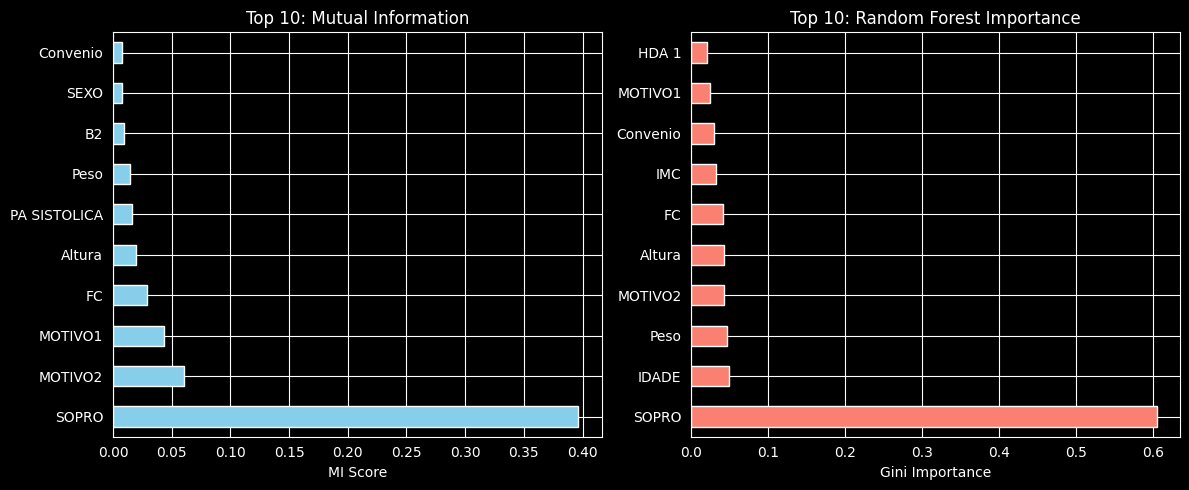

In [116]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_mi, y)
rf_results = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 5))

# Plot Mutual Information
plt.subplot(1, 2, 1)
mi_results.head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10: Mutual Information")
plt.xlabel("MI Score")

# Plot RF Importance
plt.subplot(1, 2, 2)
rf_results.head(10).plot(kind='barh', color='salmon')
plt.title("Top 10: Random Forest Importance")
plt.xlabel("Gini Importance")

plt.tight_layout()
plt.show()

In [117]:
selection_summary = pd.DataFrame({
    'MI_Score': mi_results,
    'RF_Importance': rf_results
}).sort_values(by='MI_Score', ascending=False)

selection_summary


,MI_Score,RF_Importance
SOPRO,0.396472,0.604516
MOTIVO2,0.060356,0.042605
MOTIVO1,0.043535,0.024558
FC,0.028795,0.041550
Altura,0.019514,0.042455
PA SISTOLICA,0.016022,0.020926
Peso,0.014452,0.046075
B2,0.009333,0.017889
SEXO,0.007915,0.007949
Convenio,0.007689,0.029765


In [118]:
scaler = MinMaxScaler()
selection_summary[['MI_Scaled', 'RF_Scaled']] = scaler.fit_transform(selection_summary[['MI_Score', 'RF_Importance']])
selection_summary['Combined_Score'] = (selection_summary['MI_Scaled'] + selection_summary['RF_Scaled']) / 2
selection_summary = selection_summary.sort_values(by='Combined_Score', ascending=False)
print("Top 8 Features (Combined Consensus):")
print(selection_summary.head(8))

Top 8 Features (Combined Consensus):
              MI_Score  RF_Importance  MI_Scaled  RF_Scaled  Combined_Score
SOPRO         0.396472       0.604516   1.000000   1.000000        1.000000
MOTIVO2       0.060356       0.042605   0.152234   0.068517        0.110375
MOTIVO1       0.043535       0.024558   0.109806   0.038601        0.074203
FC            0.028795       0.041550   0.072629   0.066769        0.069699
Altura        0.019514       0.042455   0.049218   0.068268        0.058743
Peso          0.014452       0.046075   0.036452   0.074269        0.055360
IDADE         0.003913       0.048800   0.009870   0.078787        0.044329
PA SISTOLICA  0.016022       0.020926   0.040410   0.032579        0.036495


In [119]:
selected_features = selection_summary.head(8).index.tolist()
print("\nSelected Features for Modeling:", selected_features)


Selected Features for Modeling: ['SOPRO', 'MOTIVO2', 'MOTIVO1', 'FC', 'Altura', 'Peso', 'IDADE', 'PA SISTOLICA']


## Data Preprocessing and Data Spliting

In [120]:
y = df['NORMAL X ANORMAL'].map({'NORMAL': 0, 'ANORMAL': 1})
X_raw = df.drop(columns=['NORMAL X ANORMAL'], errors='ignore')

cat_cols = X_raw.select_dtypes(include=['object', 'category']).columns

cat_imputer = SimpleImputer(strategy='most_frequent')
X_raw[cat_cols] = cat_imputer.fit_transform(X_raw[cat_cols])

X_encoded = pd.get_dummies(X_raw, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Handle Missing Values
num_imputer = SimpleImputer(strategy='median')
X_train_imputed = num_imputer.fit_transform(X_train)
X_test_imputed = num_imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [121]:
X_raw_no_sopro = df.drop(columns=['NORMAL X ANORMAL','SOPRO'], errors='ignore')

current_cat_cols = [col for col in cat_cols if col in X_raw_no_sopro.columns]

X_raw_no_sopro[current_cat_cols] = cat_imputer.fit_transform(X_raw_no_sopro[current_cat_cols])

X_encoded_no_sopro = pd.get_dummies(X_raw_no_sopro, drop_first=True)

X_train_no_sopro, X_test_no_sopro, y_train_no_sopro, y_test_no_sopro = train_test_split(X_encoded_no_sopro, y, test_size=0.2, random_state=42, stratify=y)

# Handle Missing Values
X_train_imputed_no_sopro = num_imputer.fit_transform(X_train_no_sopro)
X_test_imputed_no_sopro = num_imputer.transform(X_test_no_sopro)

scaler = StandardScaler()
X_train_scaled_no_sopro = scaler.fit_transform(X_train_imputed_no_sopro)
X_test_scaled_no_sopro = scaler.transform(X_test_imputed_no_sopro)

In [122]:
X_raw_selected = df[selected_features].copy()

current_cat_cols_selected = [col for col in cat_cols if col in X_raw_selected.columns]

X_raw_selected[current_cat_cols_selected] = cat_imputer.fit_transform(X_raw_selected[current_cat_cols_selected])

X_encoded_selected = pd.get_dummies(X_raw_selected, drop_first=True)

X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_encoded_selected, y, test_size=0.2, random_state=42, stratify=y)

X_train_imputed_selected = num_imputer.fit_transform(X_train_selected)
X_test_imputed_selected = num_imputer.transform(X_test_selected)

scaler_selected = StandardScaler()
X_train_scaled_selected = scaler_selected.fit_transform(X_train_imputed_selected)
X_test_scaled_selected = scaler_selected.transform(X_test_imputed_selected)

## Modelling and Evaluation

In [123]:
def build_mln(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(256,activation = 'relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [128]:
def evaluate_models(X_train, X_test, y_train, y_test):

    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier( eval_metric='logloss', random_state=42),
        "SVM": SVC(probability=True, random_state=42),
        "Mln": build_mln(X_train.shape[1])
    }

    results = []

    for name, model in models.items():
        if name == "Mln":
            model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

            y_probs = model.predict(X_test)
            y_pred = (y_probs > 0.5).astype(int).flatten()
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
        })

    return pd.DataFrame(results),models["Random Forest"]

In [140]:
results, rf_model = evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)
print(results)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.918452   0.949309  0.811024  0.874735
1        Random Forest  0.920525   0.955916  0.811024  0.877529
2              XGBoost  0.910159   0.933486  0.801181  0.862288
3                  SVM  0.906704   0.924829  0.799213  0.857445
4                  Mln  0.901866   0.889362  0.822835  0.854806


Random Forest is the most accurate and precise model, making it the most reliable for confirming a diagnosis while minimizing unnecessary stress for families. However, from a clinical safety perspective, the MLP is the most effective screening tool because its higher recall ensures fewer sick children are missed. While Logistic Regression and XGBoost offer strong performance, the MLP’s ability to catch more cases is vital in a pediatric setting where missing a condition is more dangerous than a false alarm. Because all models still fail to identify about 20% of cardiac cases, they should be used to help doctors prioritize patients rather than as a final diagnostic tool.

In [141]:
results_selected_features , rf_model_selected_features = evaluate_models(X_train_scaled_selected,X_test_scaled_selected,y_train_selected,y_test_selected)
print(results_selected_features)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.917070   0.955399  0.801181  0.871520
1        Random Forest  0.916379   0.955294  0.799213  0.870311
2              XGBoost  0.911541   0.941860  0.797244  0.863539
3                  SVM  0.915688   0.950935  0.801181  0.869658
4                  Mln  0.910159   0.927602  0.807087  0.863158


Using only the eight most relevant features, Logistic Regression emerges as the most effective model for clinical diagnosis, achieving the highest accuracy and precision while offering the transparency doctors need to trust an AI's decision. However, the MLP remains the superior choice for initial screening because it maintains the highest recall, ensuring that the maximum number of children with cardiac conditions are identified even with a smaller set of data points. The fact that performance remains high with only eight features is clinically significant, as it suggests that a streamlined, faster evaluation focusing on core variables can be nearly as effective as a full diagnostic panel. Ultimately, while Logistic Regression provides the most reliable confirmation of disease, the MLP should still be prioritized as the first-line safety net to prevent missing a critical pediatric case.

In [142]:
results_no_sopro , rf_model_no_sopro = evaluate_models(X_train_scaled_no_sopro,X_test_scaled_no_sopro,y_train_no_sopro,y_test_no_sopro)
print(results_no_sopro)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.748445   0.723602  0.458661  0.561446
1        Random Forest  0.741534   0.694767  0.470472  0.561033
2              XGBoost  0.727021   0.644501  0.496063  0.560623
3                  SVM  0.742916   0.726667  0.429134  0.539604
4                  Mln  0.722184   0.609504  0.580709  0.594758


Removing the heart murmur feature causes a massive drop in overall performance, proving that this clinical sign is the most vital predictor for pediatric cardiac disease. With these new results, the MLP remains the safest choice because it maintains the highest recall, but a recall of 58% is clinically alarming as it would miss nearly half of all sick children. Logistic Regression and SVM are the most accurate for identifying healthy patients, yet their very low sensitivity makes them dangerous to use as primary screening tools without physical exam data. Ultimately, these models demonstrate that without key clinical indicators like a murmur, the AI's ability to safely prioritize pediatric patients is severely diminished.

In [143]:
original_cols = X_raw_no_sopro.columns

def map_to_original(feature_name):
    for col in original_cols:
        if feature_name.startswith(col):
            return col
    return feature_name

rf_importance_df['Original_Feature'] = rf_importance_df['Feature'].apply(map_to_original)

grouped_importance = rf_importance_df.groupby('Original_Feature')['Importance'].sum().reset_index()

grouped_importance = grouped_importance.sort_values(by='Importance', ascending=False)

print(grouped_importance.head(10))

   Original_Feature  Importance
5             IDADE    0.127695
2          Convenio    0.117979
12             Peso    0.115329
0            Altura    0.108865
8           MOTIVO2    0.107409
3                FC    0.101192
6               IMC    0.080772
10     PA SISTOLICA    0.057148
9     PA DIASTOLICA    0.051270
7           MOTIVO1    0.040444


## Discussion and Main Conclusion

This discussion evaluates the performance of five machine learning models, Logistic Regression, Random Forest, XGBoost, SVM, and Neural Networks (MLP), across three different feature selection scenarios.

#### 1. The 67% Baseline Challenge

In this dataset, the majority class represents 67% of the patients. This means a "dummy" model that simply predicts "NORMAL" for every child would achieve 67% Accuracy.
- Clinical Significance: Any model used in a hospital must significantly outperform this 67% baseline to be considered useful.
- Observation: In Scenarios 1 and 2, our models achieve ~91-92% accuracy, representing a massive 24-25% improvement over the baseline. However, in Scenario 3 (without heart murmurs), the accuracy drops to ~73%, which is only marginally better than a blind guess, rendering the models clinically unreliable.

#### 2. Scenario Comparison

##### Scenario A: Full Feature Set

- Top Performance: Logistic Regression and Random Forest lead with ~92% accuracy and high precision (~95%).
- Safety First: The MLP (Neural Network) achieves the highest Recall (0.82). In pediatric cardiology, catching 82% of sick children is safer than catching 81%, making the MLP the preferred screening tool despite having slightly lower overall accuracy.

##### Scenario B: Top 8 Relevant Features

- Efficiency: Performance remains nearly identical to the full feature set .
- Clinical Utility: This proves that we can create a "streamlined" screening tool. By focusing only on the 8 most critical markers, clinicians can save time without sacrificing the model's ability to detect disease.

##### Scenario C: Excluding Heart Murmur

- The "Collapse" of Sensitivity: When the "Sopro" (Heart Murmur) feature is removed, Recall plunges from 0.81 down to 0.45 for Logistic Regression.
- Clinical Risk: Without the murmur data, the models miss more than half of the sick children. This confirms that the heart murmur is the most critical diagnostic anchor. AI cannot yet replace the physical exam (auscultation) in pediatric cardiac screening; it can only augment it.

#### 3. Key Clinical Metrics

- Recall (Sensitivity): This is our priority. A high recall ensures that sick children are not sent home with a "normal" result. The MLP consistently wins this category across all tests.
- Precision: Random Forest and Logistic Regression excel here. High precision prevents "False Alarms," which reduces parental anxiety and avoids clogging the healthcare system with unnecessary specialist referrals.
- Interpretability: Since Logistic Regression performed almost as well as complex models like XGBoost, it is a strong candidate for clinical use. Doctors can easily see how a specific variable (like high blood pressure) contributed to a child's risk score.

#### 4. Final Recommendations

- For Initial Screening: The MLP (Neural Network) is recommended due to its superior Recall. It acts as a safety net to catch as many potential cases as possible.
- For Diagnostic Confirmation: Random Forest is recommended. Its 95.5% precision ensures that if the model flags a child, there is a very high probability of a cardiac condition, justifying further invasive tests.
- Practical Implementation: The model is highly effective when it includes physical exam findings (Sopro). A practical tool should use the "Top 8" feature set but must strictly require the clinician to input whether a heart murmur was detected during the physical exam.